In [ ]:
# %pip install -U pip datasets ipywidgets
# For mac OS
# %pip install -U tensorflow==2.16.2 tensorflow-macos==2.16.2 keras==3.4.1 keras-nlp
# For Intel mac
# %pip install -U tensorflow==2.16.2 keras==3.4.1 keras-nlp
# For AWS SageMaker
# %pip install -U tensorflow==2.16.2 tensorflow-datasets keras==3.4.1 keras-nlp datasets

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [1]:
# Utility function to determine where this note is running
import platform

def is_running_on_apple_silicon():
    return platform.system() == "Darwin" and platform.processor() == "arm"

def is_running_on_intel_mac():
    return platform.system() == "Darwin" and platform.processor() == "i386"

DEVELOPMENT = is_running_on_apple_silicon()
DEBUGGER_V2 = False

In [2]:
import tensorflow as tf
import keras
import keras_nlp
print("Tensorflow 2.16.2 is expected. The running version is", tf.__version__)
print("Keras 3.4.1 is expected. The running version is", keras.__version__)
print("KerasNLP 0.12.1 is expected. The running version is", keras_nlp.__version__)

if is_running_on_apple_silicon() or is_running_on_intel_mac():
    FLOAT_TYPE = tf.float32
else:
    """
    # Mixed-precision training
    Deep Learning with Python, Second Edition
    François Chollet

    However, this makes the processing 2.x slower on M2 Apple Silicon.

    Machine | 1 step
    --- | ---
    Intel Mac fp16 | 12s
    Intel Mac fp32 | 7s
    Apple Silicon Mac fp16 | 1.8s
    Apple Silicon Mac fp32 | 640ms
    ml.p3.2xlarge | 166ms
    """
    keras.mixed_precision.set_global_policy("mixed_float16")
    FLOAT_TYPE = tf.float16

import numpy as np
import tensorflow_datasets as tfds
# SageMaker cannot use @keras.saving
from keras import saving
import datetime

Tensorflow 2.16.2 is expected. The running version is 2.16.2
Keras 3.4.1 is expected. The running version is 3.4.1
KerasNLP 0.12.1 is expected. The running version is 0.12.1


# Utility function

In [3]:
import matplotlib.pyplot as plt

def plot(history, title=None, keys=["loss", "masked_acc"]):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    :param keys: keys for plotting.
    """
    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(keys):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()

    for key in keys:
        if 'loss' in key:
            print(
                np.min(history.history[f"val_{key}"]),
                "The best number of epocs for the validation loss is",
                np.argmin(history.history[f"val_{key}"]) + 1,
            )
        else:
            print(
                np.max(history.history[f"val_{key}"]),
                "The best number of epocs for the validation accuracy is",
                np.argmax(history.history[f"val_{key}"]) + 1,
            )

In [4]:
def plot_model(model, custom_objects={}):
    if isinstance(model, str):
        model = keras.models.load_model(
            model,
            custom_objects=custom_objects
        )
    keras.utils.plot_model(
        model,
        show_shapes=True,
        expand_nested=True
    )

In [5]:
def get_log_dir(now):
    log_dir = "logs/fit/" + now.strftime("%Y%m%d-%H%M%S")
    return log_dir

def get_tensorboard_callback(now):
    # @see https://www.tensorflow.org/tensorboard/get_started
    log_dir = get_log_dir(now=now)
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    )
    return tensorboard_callback

In [6]:
# @see https://github.com/keras-team/keras-nlp/blob/50e041487b1d8b30b34c5fb738db3ed3406363bc/examples/machine_translation/data.py
import string
import re

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

@saving.register_keras_serializable()
def custom_standardization(input_string):
    s = tf.strings.lower(input_string)
    s = tf.strings.regex_replace(s, r'\n', ' ')
    s = tf.strings.regex_replace(s, r'\\n', ' ')
    s = tf.strings.regex_replace(s, r'<br />', ' ')
    s = tf.strings.regex_replace(s, r"'", ' ')
    s = tf.strings.regex_replace(s, r'&amp;', '')
    s = tf.strings.regex_replace(s, r'[_"\-;%()|+&=*%.,!?:#$@/]', ' ')
    s = tf.strings.regex_replace(s, r'<\/?[^>]*>', '') # html tag
    #s = tf.strings.regex_replace(s, r'''<("[^"]*"|'[^']*'|[^'">])*>''', '') # html tag
    s = tf.strings.regex_replace(s, r'https?:\/\/.*[\r\n]*', " ") # URL
    s = tf.strings.regex_replace(s, "[%s]" % re.escape(strip_chars), "")
    return s

In [7]:
def get_exponential_decay_learning_rate(initial_learning_rate, decay_steps, decay_rate):
    if decay_rate < 1.0:
        learning_rate = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
        )
        return learning_rate
    else:
        return initial_learning_rate

def get_default_optimizer(initial_learning_rate, decay_steps, decay_rate):
    learning_rate = get_exponential_decay_learning_rate(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
    )
    if f"{keras.__version__}".startswith("2.") and (is_running_on_apple_silicon() or is_running_on_intel_mac()):
        optimizer = keras.optimizers.legacy.Adam(
            learning_rate=learning_rate,
        )
    else:
        optimizer = keras.optimizers.Adam(
            learning_rate=learning_rate,
        )
    return optimizer


In [8]:
"""
### The reason why the masked loss is required for seq2seq models

The prediction y values of seq2seq models contain pad(s), which are used to align the length of every output sequence.
In the case that most sequences are much shorter than the longest sentence and pads are not considered,
a model that predicts only pads of sentences is highly evaluated.
Therefore, excluding pads from the loss calculation improves the model.

### The reason why the classification model does not use the masked loss function

The prediction y values of classification models do not contain pad(s), which are used to align the length of every output sequence.
It just contains the probability of each class.
"""

# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
@saving.register_keras_serializable()
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        # nn.py:609: UserWarning:
        # "`sparse_categorical_crossentropy` received `from_logits=True`,
        # but the `output` argument was produced by a Softmax activation and thus does not represent logits.
        # Was this intended?
        # When logits is True, softmax activation function has not processed the values.
        # from_logits=True,
        reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, dtype=loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [9]:
# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
# def masked_acc(y_true, y_pred):
#     # Calculate the loss for each item in the batch.
#     y_pred = tf.argmax(y_pred, axis=-1)
#     y_pred = tf.cast(y_pred, dtype=y_true.dtype)
#     match = tf.cast(y_true == y_pred, dtype=FLOAT_TYPE)
#     mask = tf.cast(y_true != 0, dtype=FLOAT_TYPE)
#     return tf.reduce_sum(match)/tf.reduce_sum(mask)

# @see https://www.tensorflow.org/text/tutorials/transformer
@saving.register_keras_serializable()
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=2)
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    match = y_true == y_pred
    mask = y_true != 0
    match = match & mask
    match = tf.cast(match, dtype=FLOAT_TYPE)
    mask = tf.cast(mask, dtype=FLOAT_TYPE)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [10]:
@saving.register_keras_serializable()
class BaseSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, **kwargs):
        super().__init__()
        self.lr = kwargs['lr']
        self.decay_start =  kwargs.get('decay_start', 0.0)
        self.decay_ratio = kwargs.get('decay_ratio', 1.0)
        self.beta_2 = kwargs.get('beta_2', 0.999)

    def get_config(self):
        config = {
            "lr": float(self.lr), 
            "decay_start": float(self.decay_start),
            "decay_ratio": float(self.decay_ratio),
            "beta_2": float(self.beta_2)
        }
        tf.print('get_config')
        return config

    def __call__(self, step):
        return tf.where(
            step >= self.decay_start,
            self.decay_ratio*self.lr,
            self.lr
        )

@saving.register_keras_serializable()
class RectifiedAdamSchedule(BaseSchedule):
    def __call__(self, step):
        lr = super().__call__(step)
        f_step = tf.cast(step, tf.float32)
        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        beta2_power = tf.pow(self.beta_2, f_step)
        sma_t = sma_inf - 2.0 * f_step * beta2_power / (1.0 - beta2_power)
        r_t =  tf.sqrt((sma_t - 4.0) / (sma_inf - 4.0) * (sma_t - 2.0) / (sma_inf - 2.0) * sma_inf / sma_t)
        return tf.where(
            sma_t > 4.0,
            r_t*lr,
            0.0
        )

@saving.register_keras_serializable()
class ExponentialWarmupSchedule(BaseSchedule):
    def __call__(self, step):
        lr = super().__call__(step)
        f_step = tf.cast(step, tf.float32)
        return (1.0 - tf.math.exp( -(1.0-self.beta_2)*f_step ))*lr

@saving.register_keras_serializable()
class LinearWarmupSchedule(BaseSchedule):
    def __call__(self, step):
        lr = super().__call__(step)
        f_step = tf.cast(step, tf.float32)
        return tf.math.minimum( 1.0, (1-self.beta_2)/2*f_step )*lr


## Dataset

In [11]:
def prepare_datasets():
    if is_running_on_apple_silicon():
        args = {
            'trust_remote_code': False,
        }
    else:
        # This is necessary for the first time.
        args = {
            'trust_remote_code': True,
        }
    # OpenSSL 3 causes the following error.
    # MaxRetryError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/datasets (Caused by SSLError("Can't connect to HTTPS URL because the SSL module is not available."))
    # SSLError: (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /api/datasets (Caused by SSLError("Can\'t connect to HTTPS URL because the SSL module is not available."))'), '(Request ID: 45635ea8-321e-4c9b-8d32-2fef20c22f78)')
    train_ds, validation_ds, test_ds = tfds.load(
        'huggingface:ccdv__cnn_dailymail/3.0.0',
        split=['train', 'validation', 'test'],
        builder_kwargs=args,
    )
    # for development with 1/10 entries
    if DEVELOPMENT:
        train_size = len(train_ds) // 100 * 90
        validation_size = len(validation_ds) // 100 * 90
        test_size = len(test_ds) // 100 * 90
        train_ds = train_ds.skip(train_size)
        validation_ds = validation_ds.skip(validation_size)
        test_ds = test_ds.skip(test_size)
    return train_ds, validation_ds, test_ds

In [12]:
def prepare_tokenizer(
        vectorization_layer,
        encoder_sequence_length,
        decoder_sequence_length,
        max_tokens=15000):
    """
    Display the plot that indicates the loss and accuracy.
    :param vectorization_layer: obtain vocabulary.
    :param max_tokens: In other words, this is the vocabulary size.
    :param encoder_sequence_length: The sequence length for input.
    :param input_output_sequence_length: The sequence length for target.
    """
    vocabulary = vectorization_layer.get_vocabulary()

    input_vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=encoder_sequence_length,
    )
    target_vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=decoder_sequence_length,
    )
    input_vectorization_layer.set_vocabulary(vocabulary)
    target_vectorization_layer.set_vocabulary(vocabulary)
    return input_vectorization_layer, target_vectorization_layer

def build_datasets(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        batch_size,
        encoder_sequence_length,
        decoder_sequence_length):
    """
    vectorization_layer(['This is a pen', 'I am a software engineer'])
    #vectorization_layer(['This is a pen', 'I am a software engineer']).row_lengths().shape[0]
    # 2
    rows = vectorization_layer(['This is a pen', 'I am a software engineer']).row_lengths().shape[0]
    vectorization_layer(['This is a pen', 'I am a software engineer']).to_tensor(shape=(rows, 10))
    # .to_tensor()

    RaggedTensor.to_tensor can make 0-filled Tensor
    """
    def format_dataset(x):
        # decoder_sequence_length: either the following 2.
        # - decoder input: [start] + sentence
        # - decoder output: sentence + [end]
        # That is, decoder_sequence_length = sentence length + 1
        summarized_text_length = decoder_sequence_length - 1

        # The following code with input_vectorization_layer makes the (None, None) shape Tensor.
        # Therefore, vectorization_layer is used instead.
        # article = input_vectorization_layer(x['article'])
        # tf.print(article[:, :30])
        # tf.print(article.shape) # (None, None) why?
        # tf.print(highlights_decoder_input.shape) # (None, decoder_sequence_length)
        # tf.print(highlights_decoder_output.shape) # (None, decoder_sequence_length)

        a = vectorization_layer(x['article'])
        r = a.row_lengths().shape[0]
        article = a.to_tensor(shape=(r, encoder_sequence_length))

        highlights = tf.strings.join(['[start] ', x['highlights'], ' [end]'])
        h = vectorization_layer(highlights)
        rows = h.row_lengths().shape[0]
        sequences = h.to_tensor(shape=(rows, summarized_text_length + 1 + 1)) # start + sentence + end

        highlights_decoder_input = sequences[:, :-1] # start + sentence
        highlights_decoder_output = sequences[:, 1:] # sentence + end
        return (
            (
                article, # encoder input
                highlights_decoder_input, # decoder input
            ),
            highlights_decoder_output, # decoder output
            tf.cast((highlights_decoder_output != 0), dtype=FLOAT_TYPE)
        )
    train_ds = train_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    validation_ds = validation_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    test_ds = test_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    return train_ds, validation_ds, test_ds


## Model

In [13]:
@saving.register_keras_serializable()
class TransformerEncoderDecoderModel(keras.Model):
    def __init__(
        self,
        encoder_tokenizer,
        decoder_tokenizer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_vocabulary_size,
        decoder_vocabulary_size,
        embedding_dim,
        mask_zero,
        encoder_sequence_length,
        decoder_sequence_length,
        **kwargs):
        super(TransformerEncoderDecoderModel, self).__init__(**kwargs)
        self.mask_zero = mask_zero
        self.layer_norm_epsilon = layer_norm_epsilon
        self.encoders = []
        self.decoders = []
        if isinstance(layer_norm_epsilon, list):
            encoder_layer_norm_epsilons = layer_norm_epsilon
            decoder_layer_norm_epsilons = layer_norm_epsilon
        else:
            encoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_encoders)]
            decoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_decoders)]

        for i in range(num_encoders):
            self.encoders.append(
                keras_nlp.layers.TransformerEncoder(
                    num_heads=num_heads,
                    intermediate_dim=transformer_intermediate_dim,
                    normalize_first=normalize_first,
                    layer_norm_epsilon=encoder_layer_norm_epsilons[i],
                )
            )
        for _ in range(num_decoders):
            self.decoders.append(
                keras_nlp.layers.TransformerDecoder(
                    num_heads=num_heads,
                    intermediate_dim=transformer_intermediate_dim,
                    normalize_first=normalize_first,
                    layer_norm_epsilon=decoder_layer_norm_epsilons[i],
                )
            )

        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer

        self.encoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=encoder_vocabulary_size,
            sequence_length=encoder_sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=mask_zero,
        )

        self.decoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=decoder_vocabulary_size,
            sequence_length=decoder_sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=mask_zero,
        )

        self.dense = keras.layers.Dense(
            decoder_vocabulary_size,
            activation="softmax",
        )

    def build(self, input_shape):
        """
        @see https://github.com/keras-team/keras/issues/19535#issuecomment-2060299275
        fcollet has answered and explained how to implement for the following warning.

        ```
        UserWarning: `build()` was called on layer 'transformer_encoder_decoder_model_*',
        however the layer does not have a `build()` method implemented and it looks like it has unbuilt state.
        This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line.
        Make sure to implement a proper `build()` method
        ```

        The incorrect implementation of this method causes the following problem:
        - When the model is generated from .keras file, the loaded model does not work correctly.
        """
        self.encoder_embedding.build(input_shape[0])
        self.decoder_embedding.build(input_shape[1])
        encoder_output_shape = self.encoder_embedding.compute_output_shape(input_shape[0])
        decoder_output_shape = self.decoder_embedding.compute_output_shape(input_shape[1])

        for encoder in self.encoders:
            encoder.build(inputs_shape=encoder_output_shape)
            encoder_output_shape = encoder.compute_output_shape(
                inputs_shape=encoder_output_shape
            )
        for decoder in self.decoders:
            decoder.build(
                decoder_sequence_shape=decoder_output_shape,
                encoder_sequence_shape=encoder_output_shape,
            )
            decoder_output_shape = decoder.compute_output_shape(
                decoder_sequence_shape=decoder_output_shape,
            )

        self.dense.build(input_shape=decoder_output_shape)
        self.built = True

    def call(self, inputs, training=False):
        encoder_input, decoder_input = (
            inputs[0],
            inputs[1],
        )
        encoded = self.encoder_embedding(encoder_input)
        for encoder in self.encoders:
            encoded = encoder(
                inputs=encoded,
                training=training,
            )

        decoded = self.decoder_embedding(decoder_input)
        for decoder in self.decoders:
            decoded = decoder(
                decoder_sequence=decoded,
                encoder_sequence=encoded,
                use_causal_mask=True,
                training=training,
            )

        output = self.dense(decoded)
        return output

    def get_config(self):
        #config = super(TransformerEncoderDecoderModel, self).get_config()
        config = super(TransformerEncoderDecoderModel, self).get_config().copy()
        config.update({
            "encoder_tokenizer": self.encoder_tokenizer.get_config(),
            "decoder_tokenizer": self.decoder_tokenizer.get_config(),
            "num_encoders": len(self.encoders),
            "num_decoders": len(self.decoders),
            "num_heads": self.encoders[0].num_heads,
            "transformer_intermediate_dim": self.encoders[0].intermediate_dim,
            "normalize_first": self.encoders[0].normalize_first,
            "layer_norm_epsilon": self.layer_norm_epsilon,
            "encoder_vocabulary_size": self.encoder_embedding.vocabulary_size,
            "decoder_vocabulary_size": self.decoder_embedding.vocabulary_size,
            "embedding_dim": self.encoder_embedding.embedding_dim,
            "mask_zero": self.mask_zero,
            "encoder_sequence_length": self.encoder_embedding.sequence_length,
            "decoder_sequence_length": self.decoder_embedding.sequence_length,
        })
        return config
    @classmethod
    def from_config(cls, config):
        encoder_tokenizer_config = config.pop("encoder_tokenizer")
        decoder_tokenizer_config = config.pop("decoder_tokenizer")
        encoder_tokenizer = keras.layers.TextVectorization.from_config(encoder_tokenizer_config)
        decoder_tokenizer = keras.layers.TextVectorization.from_config(decoder_tokenizer_config)
        return cls(
            encoder_tokenizer=encoder_tokenizer,
            decoder_tokenizer=decoder_tokenizer,
            **config
        )

## Train

In [14]:
def run_training(
        model,
        train_ds,
        validation_ds,
        optimizer,
        epochs,
        steps_per_epoch,
        now,
        callbacks=[]):
    if f"{keras.__version__}".startswith("2."):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            reduction=keras.losses.Reduction.NONE
        )
    else:
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            reduction=None
        )
    metrics = [
        masked_acc,
        #keras.metrics.SparseCategoricalAccuracy(),
        #keras_nlp.metrics.Bleu(), #  This cannot be used here
    ]
    model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss=masked_loss,
        weighted_metrics=[],
    )
    callbacks.append(get_tensorboard_callback(now=now))
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=validation_ds,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
    )
    return history


In [15]:
def build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_sequence_length,
        decoder_sequence_length,
        vocab_size,
        batch_size,
        embedding_dim,
        mask_zero,
        optimizer,
        epochs,
        steps_per_epoch,
        callbacks=[]):
    now = datetime.datetime.now()
    if DEBUGGER_V2:
        tf.debugging.experimental.enable_dump_debug_info(
            get_log_dir(now=now),
            tensor_debug_mode="FULL_HEALTH",
            circular_buffer_size=-1
        )
    input_vectorization_layer, target_vectorization_layer = prepare_tokenizer(
        vectorization_layer=vectorization_layer,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        max_tokens=vocab_size,
    )
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        vectorization_layer=vectorization_layer,
        batch_size=batch_size,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )

    input_vocab_size = input_vectorization_layer.vocabulary_size()
    target_vocab_size = target_vectorization_layer.vocabulary_size()
    model = TransformerEncoderDecoderModel(
        encoder_tokenizer=input_vectorization_layer,
        decoder_tokenizer=target_vectorization_layer,
        num_encoders=num_encoders,
        num_decoders=num_decoders,
        num_heads=num_heads,
        transformer_intermediate_dim=transformer_intermediate_dim,
        normalize_first=normalize_first,
        layer_norm_epsilon=layer_norm_epsilon,
        encoder_vocabulary_size=input_vocab_size,
        decoder_vocabulary_size=target_vocab_size,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )
    # This should be called seemingly.
    model.build(
        input_shape=(
            (None, encoder_sequence_length),
            (None, decoder_sequence_length)
        )
    )

    history = run_training(
        model,
        train_ds=train_ds,
        validation_ds=validation_ds,
        optimizer=optimizer,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        now=now,
        callbacks=callbacks,
    )

    timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
    if is_running_on_apple_silicon() or is_running_on_intel_mac():
        filepath = f'model/summarization_model_{timestamp}.keras'
    else:
        filepath = f'summarization_model_{timestamp}.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


# Functional API

In [16]:
# Functional API cannot hold tokenizer inside.
# They must be saved externally.
def create_model_functionally(
        encoder_tokenizer,
        decoder_tokenizer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_vocabulary_size,
        decoder_vocabulary_size,
        embedding_dim,
        mask_zero,
        encoder_sequence_length,
        decoder_sequence_length):
    if isinstance(layer_norm_epsilon, list):
        encoder_layer_norm_epsilons = layer_norm_epsilon
        decoder_layer_norm_epsilons = layer_norm_epsilon
    else:
        encoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_encoders)]
        decoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_decoders)]

    encoder_inputs = keras.Input(
        shape=(encoder_sequence_length,),
        name="encoder_inputs",
        dtype="int64",
    )
    decoder_inputs = keras.Input(
        shape=(decoder_sequence_length,),
        name="decoder_inputs",
        dtype="int64",
    )

    # encoder_tokenized_outputs = encoder_tokenizer(encoder_inputs)
    # decoder_tokenized_outputs = decoder_tokenizer(decoder_inputs)

    encoder_outputs = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=encoder_vocabulary_size,
        sequence_length=encoder_sequence_length,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
    )(encoder_inputs)

    decoder_outputs = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=decoder_vocabulary_size,
        sequence_length=decoder_sequence_length,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
    )(decoder_inputs)

    for i in range(num_encoders):
        encoder_outputs = keras_nlp.layers.TransformerEncoder(
            num_heads=num_heads,
            intermediate_dim=transformer_intermediate_dim,
            normalize_first=normalize_first,
            layer_norm_epsilon=encoder_layer_norm_epsilons[i],
        )(inputs=encoder_outputs)
    for i in range(num_decoders):
        decoder_outputs = keras_nlp.layers.TransformerDecoder(
            num_heads=num_heads,
            intermediate_dim=transformer_intermediate_dim,
            normalize_first=normalize_first,
            layer_norm_epsilon=decoder_layer_norm_epsilons[i],
        )(
            decoder_sequence=decoder_outputs,
            encoder_sequence=encoder_outputs,
            use_causal_mask=True,
        )
    outputs = keras.layers.Dense(
        decoder_vocabulary_size,
        activation="softmax"
    )(decoder_outputs)

    model = keras.Model(
        inputs=[encoder_inputs, decoder_inputs],
        outputs=outputs,
        name="transformer_encoder_decoder_model"
    )
    return model

def build_model_functionally(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_sequence_length,
        decoder_sequence_length,
        vocab_size,
        batch_size,
        embedding_dim,
        mask_zero,
        optimizer,
        epochs,
        steps_per_epoch,
        callbacks=[]):
    now=datetime.datetime.now()
    if DEBUGGER_V2:
        tf.debugging.experimental.enable_dump_debug_info(
            get_log_dir(now=now),
            tensor_debug_mode="FULL_HEALTH",
            circular_buffer_size=-1
        )
    input_vectorization_layer, target_vectorization_layer = prepare_tokenizer(
        vectorization_layer=vectorization_layer,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        max_tokens=vocab_size,
    )
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        vectorization_layer=vectorization_layer,
        batch_size=batch_size,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )

    input_vocab_size = input_vectorization_layer.vocabulary_size()
    target_vocab_size = target_vectorization_layer.vocabulary_size()
    model = create_model_functionally(
        encoder_tokenizer=input_vectorization_layer,
        decoder_tokenizer=target_vectorization_layer,
        num_encoders=num_encoders,
        num_decoders=num_decoders,
        num_heads=num_heads,
        transformer_intermediate_dim=transformer_intermediate_dim,
        normalize_first=normalize_first,
        layer_norm_epsilon=layer_norm_epsilon,
        encoder_vocabulary_size=input_vocab_size,
        decoder_vocabulary_size=target_vocab_size,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )
    model.summary()

    history = run_training(
        model,
        train_ds=train_ds,
        validation_ds=validation_ds,
        optimizer=optimizer,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        now=now,
        callbacks=callbacks,
    )

    timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
    if is_running_on_apple_silicon() or is_running_on_intel_mac():
        filepath = f'model/summarization_model_{timestamp}.keras'
    else:
        filepath = f'summarization_model_{timestamp}.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


# Decode and Predict

In [17]:
EXAMPLES = [
    """(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victory was never seriously in doubt once he got the baton safely in hand from Ashmeade, while Gatlin and the United States third leg runner Rakieem Salaam had problems. Gatlin strayed out of his lane as he struggled to get full control of their baton and was never able to get on terms with Bolt. Earlier, Jamaica\'s women underlined their dominance in the sprint events by winning the 4x100m relay gold, anchored by Shelly-Ann Fraser-Pryce, who like Bolt was completing a triple. Their quartet recorded a championship record of 41.29 seconds, well clear of France, who crossed the line in second place in 42.73 seconds. Defending champions, the United States, were initially back in the bronze medal position after losing time on the second handover between Alexandria Anderson and English Gardner, but promoted to silver when France were subsequently disqualified for an illegal handover. The British quartet, who were initially fourth, were promoted to the bronze which eluded their men\'s team. Fraser-Pryce, like Bolt aged 26, became the first woman to achieve three golds in the 100-200 and the relay. In other final action on the last day of the championships, France\'s Teddy Tamgho became the third man to leap over 18m in the triple jump, exceeding the mark by four centimeters to take gold. Germany\'s Christina Obergfoll finally took gold at global level in the women\'s javelin after five previous silvers, while Kenya\'s Asbel Kiprop easily won a tactical men\'s 1500m final. Kiprop\'s compatriot Eunice Jepkoech Sum was a surprise winner of the women\'s 800m. Bolt\'s final dash for golden glory brought the eight-day championship to a rousing finale, but while the hosts topped the medal table from the United States there was criticism of the poor attendances in the Luzhniki Stadium. There was further concern when their pole vault gold medalist Yelena Isinbayeva made controversial remarks in support of Russia\'s new laws, which make "the propagandizing of non-traditional sexual relations among minors" a criminal offense. She later attempted to clarify her comments, but there were renewed calls by gay rights groups for a boycott of the 2014 Winter Games in Sochi, the next major sports event in Russia.""",
    """Vice President Dick Cheney will serve as acting president briefly Saturday while President Bush is anesthetized for a routine colonoscopy, White House spokesman Tony Snow said Friday. Bush is scheduled to have the medical procedure, expected to take about 2 1/2 hours, at the presidential retreat at Camp David, Maryland, Snow said. Bush's last colonoscopy was in June 2002, and no abnormalities were found, Snow said. The president's doctor had recommended a repeat procedure in about five years. The procedure will be supervised by Dr. Richard Tubb and conducted by a multidisciplinary team from the National Naval Medical Center in Bethesda, Maryland, Snow said. A colonoscopy is the most sensitive test for colon cancer, rectal cancer and polyps, small clumps of cells that can become cancerous, according to the Mayo Clinic. Small polyps may be removed during the procedure. Snow said that was the case when Bush had colonoscopies before becoming president. Snow himself is undergoing chemotherapy for cancer that began in his colon and spread to his liver. Snow told reporters he had a chemo session scheduled later Friday. Watch Snow talk about Bush's procedure and his own colon cancer » . "The president wants to encourage everybody to use surveillance," Snow said. The American Cancer Society recommends that people without high-risk factors or symptoms begin getting screened for signs of colorectal cancer at age 50. E-mail to a friend .""",
    "There are two chickens in the garden.",
    "Two chickens fell into the swimming pool in the garden.",
]

def decode_sequence(
        input_sentence,
        model,
        max_sequence_length,
        lookup_table):
    encoder_tokenizer = model.encoder_tokenizer
    decoder_tokenizer = model.decoder_tokenizer
    tokenized_input = encoder_tokenizer([input_sentence])

    start_token = decoder_tokenizer("[start]")[0].numpy()
    end_token = decoder_tokenizer("[end]")[0].numpy()

    decoded_sentence = [start_token]
    for i in range(max_sequence_length):
        decoder_inputs = tf.convert_to_tensor(
            [decoded_sentence],
            dtype="int64",
        )
        decoder_inputs = tf.concat(
            [
                decoder_inputs,
                tf.zeros(
                    [1, max_sequence_length - i - 1],
                    dtype="int64",
                ),
            ],
            axis=1,
        )
        input = (
            tokenized_input,
            decoder_inputs,
        )
        predictions = model(input)
        predicted_token = np.argmax(predictions[0, i, :])
        decoded_sentence.append(predicted_token)
        if predicted_token == end_token:
            break

    detokenized_output = []
    for token in decoded_sentence:
        detokenized_output.append(lookup_table[token])
    return " ".join(detokenized_output)


def predict_main(
        filepath,
        examples,
        decoder_sequence_length):
    loaded_model = keras.models.load_model(
        filepath,
        # Just in case, TransformerEncoderDecoderModel is specified.
        # However, it does not seem necessary.
        custom_objects={
            "TransformerEncoderDecoderModel": TransformerEncoderDecoderModel,
        }
    )

    decoder_tokenizer = loaded_model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    summarized = []
    for example in examples:
        summarized.append(
            decode_sequence(
                example,
                loaded_model,
                decoder_sequence_length,
                index_lookup_table,
            )
        )

    for i in range(len(examples)):
        print("ORIGINAL SENTENCE: ", examples[i])
        print("SUMMARIZED RESULT: ", summarized[i])

def predict_model(
        model,
        examples,
        decoder_sequence_length):
    decoder_tokenizer = model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    summarized = []
    for example in examples:
        summarized.append(
            decode_sequence(
                example,
                model,
                decoder_sequence_length,
                index_lookup_table,
            )
        )

    for i in range(len(examples)):
        print("ORIGINAL SENTENCE: ", examples[i])
        print("SUMMARIZED RESULT: ", summarized[i])

***

# Build

batch size | CPU | GPU
--- | --- | ---
--- | 7m52s | > 25m
32 | 1m41s | 2m26s
64 | 1m37s | 2m5s
128 | 1m37s | 1m49s
256 | 1m31s | 1m40s

In [18]:
VOCABULARY_SIZE = 15000
ADAPT_BATCH_SIZE = 256

train_ds, validation_ds, test_ds = prepare_datasets()
vectorization_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    ragged=True,
)
vectorization_layer.adapt(
    train_ds.batch(ADAPT_BATCH_SIZE).map(
        lambda row: '[start] ' + row['article'] + ' ' + row['highlights'] + ' [end]',
        num_parallel_calls=tf.data.AUTOTUNE,
    ),
    batch_size=ADAPT_BATCH_SIZE,
)

/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tensorflow_datasets/core/dataset_builders/huggingface_dataset_builder.py:160: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  hf_names = hf_datasets.list_datasets()
2024-07-09 00:27:43.909530: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-07-09 00:27:43.909563: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-07-09 00:27:43.909567: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-07-09 00:27:43.909584: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-09 00:27:43.909598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Creat

In [ ]:
# Subclassing API - 2 layers
LEARNING_RATE = 0.001
NUM_EPOCHS = 60
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

In [ ]:
# Subclassing API - 1 layer
LEARNING_RATE = 0.001
NUM_EPOCHS = 60
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-09 00:13:00)

10% dataset

- **`NUM_ENCODERS = 1~2`**
- **`NUM_DECODERS = 1~2`**
- **Functional API, Subclassing API**
- `NORMALIZE_FIRST = True`
- `layer_norm_epsilon=1e-05`

#### Result

予想

Model: "transformer_encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 256, 64)   │    976,384 │ encoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, 256, 64)   │    152,152 │ token_and_positi… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 128, 64)   │    968,192 │ decoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 64)   │    152,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decoder │ (None, 128, 64)   │    168,920 │ token_and_positi… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 128, 64)   │    168,920 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128,       │    975,000 │ transformer_deco… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,561,720 (13.59 MB)

 Trainable params: 3,561,720 (13.59 MB)

 Non-trainable params: 0 (0.00 B)

get_config
Epoch 1/35


2024-07-09 00:27:56.604922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


449/449 ━━━━━━━━━━━━━━━━━━━━ 151s 293ms/step - loss: 3.4180 - masked_acc: 0.0396 - val_loss: 3.0702 - val_masked_acc: 0.0885
Epoch 2/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 128s 284ms/step - loss: 2.7138 - masked_acc: 0.1021 - val_loss: 2.7513 - val_masked_acc: 0.1328
Epoch 3/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 126s 280ms/step - loss: 2.4873 - masked_acc: 0.1317 - val_loss: 2.6370 - val_masked_acc: 0.1434
Epoch 4/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 127s 281ms/step - loss: 2.3759 - masked_acc: 0.1429 - val_loss: 2.5765 - val_masked_acc: 0.1501
Epoch 5/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 132s 291ms/step - loss: 2.2971 - masked_acc: 0.1510 - val_loss: 2.5341 - val_masked_acc: 0.1537
Epoch 6/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 128s 284ms/step - loss: 2.2296 - masked_acc: 0.1581 - val_loss: 2.5070 - val_masked_acc: 0.1577
Epoch 7/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 127s 282ms/step - loss: 2.1722 - masked_acc: 0.1645 - val_loss: 2.4902 - val_masked_acc: 0.1602
Epoch 8/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 126s 280ms/step - l

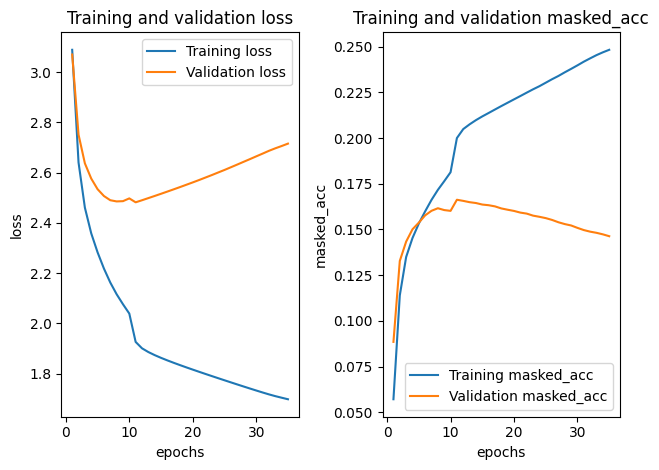

2.481921434402466 The best number of epocs for the validation loss is 11
0.1662621647119522 The best number of epocs for the validation accuracy is 11


In [19]:
# Functional API - 2 layers
LEARNING_RATE = 0.001
NUM_EPOCHS = 35
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Epoch 1/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 148s 278ms/step - loss: 3.4223 - masked_acc: 0.0457 - val_loss: 3.0687 - val_masked_acc: 0.0881
Epoch 2/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 257ms/step - loss: 2.7159 - masked_acc: 0.1001 - val_loss: 2.7464 - val_masked_acc: 0.1334
Epoch 3/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 256ms/step - loss: 2.4798 - masked_acc: 0.1329 - val_loss: 2.6346 - val_masked_acc: 0.1447
Epoch 4/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 256ms/step - loss: 2.3724 - masked_acc: 0.1441 - val_loss: 2.5827 - val_masked_acc: 0.1495
Epoch 5/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 256ms/step - loss: 2.2976 - masked_acc: 0.1511 - val_loss: 2.5427 - val_masked_acc: 0.1545
Epoch 6/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 256ms/step - loss: 2.2328 - masked_acc: 0.1571 - val_loss: 2.5155 - val_masked_acc: 0.1571
Epoch 7/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 256ms/step - loss: 2.1758 - masked_acc: 0.1635 - val_loss: 2.5002 - val_masked_acc: 0.1606
Epoch 8/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 115s 256

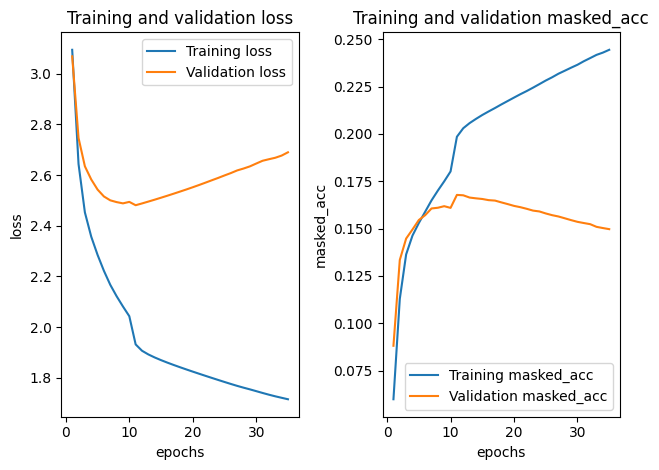

2.480922222137451 The best number of epocs for the validation loss is 11
0.1677982211112976 The best number of epocs for the validation accuracy is 11


In [20]:
# Subclassing API - 2 layers
LEARNING_RATE = 0.001
NUM_EPOCHS = 35
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Model: "transformer_encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 256, 64)   │    976,384 │ encoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 128, 64)   │    968,192 │ decoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 64)   │    152,152 │ token_and_positi… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 128, 64)   │    168,920 │ token_and_positi… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128,       │    975,000 │ transformer_deco… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,240,648 (12.36 MB)

 Trainable params: 3,240,648 (12.36 MB)

 Non-trainable params: 0 (0.00 B)

get_config
Epoch 1/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 108s 203ms/step - loss: 3.4669 - masked_acc: 0.0380 - val_loss: 3.0904 - val_masked_acc: 0.0847
Epoch 2/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 191ms/step - loss: 2.7395 - masked_acc: 0.0972 - val_loss: 2.7903 - val_masked_acc: 0.1291
Epoch 3/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - loss: 2.5209 - masked_acc: 0.1291 - val_loss: 2.6737 - val_masked_acc: 0.1409
Epoch 4/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 191ms/step - loss: 2.4147 - masked_acc: 0.1401 - val_loss: 2.6112 - val_masked_acc: 0.1468
Epoch 5/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 88s 195ms/step - loss: 2.3373 - masked_acc: 0.1475 - val_loss: 2.5708 - val_masked_acc: 0.1514
Epoch 6/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - loss: 2.2777 - masked_acc: 0.1541 - val_loss: 2.5465 - val_masked_acc: 0.1552
Epoch 7/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 90s 199ms/step - loss: 2.2256 - masked_acc: 0.1601 - val_loss: 2.5332 - val_masked_acc: 0.1547
Epoch 8/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 89s

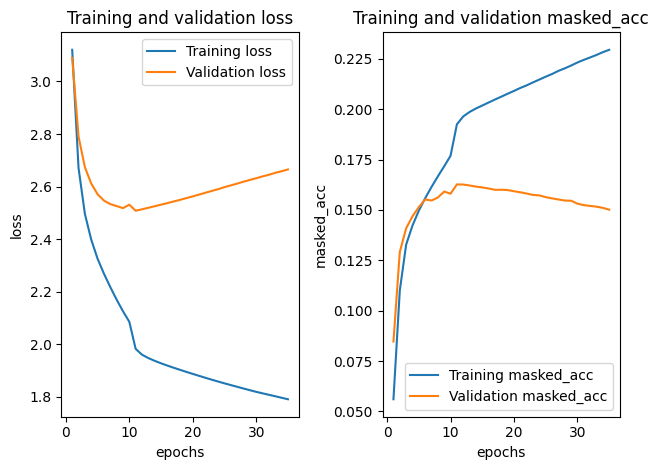

2.507861375808716 The best number of epocs for the validation loss is 11
0.1626758724451065 The best number of epocs for the validation accuracy is 11


In [21]:
# Functional API - 1 layer
LEARNING_RATE = 0.001
NUM_EPOCHS = 35
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Epoch 1/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 106s 197ms/step - loss: 3.4607 - masked_acc: 0.0439 - val_loss: 3.0809 - val_masked_acc: 0.0855
Epoch 2/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 186ms/step - loss: 2.7520 - masked_acc: 0.0957 - val_loss: 2.8023 - val_masked_acc: 0.1283
Epoch 3/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - loss: 2.5290 - masked_acc: 0.1291 - val_loss: 2.6655 - val_masked_acc: 0.1425
Epoch 4/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 188ms/step - loss: 2.4072 - masked_acc: 0.1407 - val_loss: 2.6097 - val_masked_acc: 0.1474
Epoch 5/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - loss: 2.3349 - masked_acc: 0.1475 - val_loss: 2.5765 - val_masked_acc: 0.1523
Epoch 6/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 83s 184ms/step - loss: 2.2819 - masked_acc: 0.1529 - val_loss: 2.5601 - val_masked_acc: 0.1541
Epoch 7/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - loss: 2.2358 - masked_acc: 0.1576 - val_loss: 2.5504 - val_masked_acc: 0.1555
Epoch 8/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 186ms/step

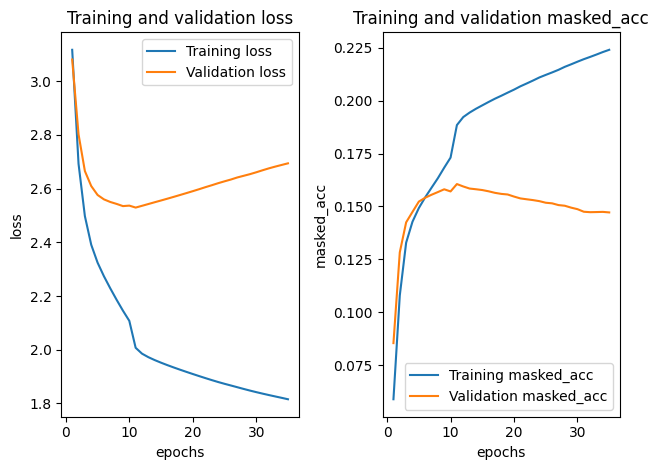

2.529484510421753 The best number of epocs for the validation loss is 11
0.16059942543506622 The best number of epocs for the validation accuracy is 11


In [22]:
# Subclassing API - 1 layer
LEARNING_RATE = 0.001
NUM_EPOCHS = 35
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Model: "transformer_encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 256, 64)   │    976,384 │ encoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 64)   │    152,152 │ token_and_positi… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 128, 64)   │    968,192 │ decoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 64)   │    152,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 128, 64)   │    168,920 │ token_and_positi… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 128, 64)   │    168,920 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128,       │    975,000 │ transformer_deco… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,561,720 (13.59 MB)

 Trainable params: 3,561,720 (13.59 MB)

 Non-trainable params: 0 (0.00 B)

get_config
Epoch 1/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 163s 301ms/step - loss: 3.4205 - masked_acc: 0.0413 - val_loss: 3.0833 - val_masked_acc: 0.0862
Epoch 2/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 125s 277ms/step - loss: 2.7354 - masked_acc: 0.0968 - val_loss: 2.7621 - val_masked_acc: 0.1303
Epoch 3/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 124s 276ms/step - loss: 2.4943 - masked_acc: 0.1290 - val_loss: 2.6377 - val_masked_acc: 0.1416
Epoch 4/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 124s 276ms/step - loss: 2.3780 - masked_acc: 0.1414 - val_loss: 2.5804 - val_masked_acc: 0.1499
Epoch 5/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 124s 276ms/step - loss: 2.3043 - masked_acc: 0.1502 - val_loss: 2.5436 - val_masked_acc: 0.1536
Epoch 6/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 124s 275ms/step - loss: 2.2425 - masked_acc: 0.1577 - val_loss: 2.5150 - val_masked_acc: 0.1575
Epoch 7/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 124s 275ms/step - loss: 2.1832 - masked_acc: 0.1644 - val_loss: 2.4983 - val_masked_acc: 0.1586
Epoch 8/35
449/449 ━━━━━━━━━━━━━━━━━━

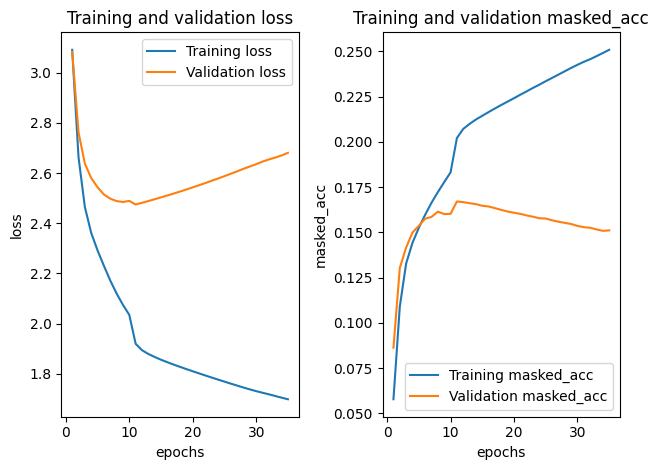

2.47505259513855 The best number of epocs for the validation loss is 11
0.1670866310596466 The best number of epocs for the validation accuracy is 11


In [23]:
# Functional API - 2 layers, norm_epsilon 1e-9
LEARNING_RATE = 0.001
NUM_EPOCHS = 35
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-9
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Model: "transformer_encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 256, 64)   │    976,384 │ encoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 64)   │    152,152 │ token_and_positi… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 128, 64)   │    968,192 │ decoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 64)   │    152,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 128, 64)   │    168,920 │ token_and_positi… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 128, 64)   │    168,920 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128,       │    975,000 │ transformer_deco… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,561,720 (13.59 MB)

 Trainable params: 3,561,720 (13.59 MB)

 Non-trainable params: 0 (0.00 B)

get_config
Epoch 1/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 171s 306ms/step - loss: 3.4155 - masked_acc: 0.0332 - val_loss: 3.0668 - val_masked_acc: 0.0883
Epoch 2/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 127s 281ms/step - loss: 2.7148 - masked_acc: 0.1008 - val_loss: 2.7461 - val_masked_acc: 0.1334
Epoch 3/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 126s 279ms/step - loss: 2.4810 - masked_acc: 0.1316 - val_loss: 2.6338 - val_masked_acc: 0.1434
Epoch 4/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 126s 279ms/step - loss: 2.3722 - masked_acc: 0.1428 - val_loss: 2.5730 - val_masked_acc: 0.1508
Epoch 5/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 125s 279ms/step - loss: 2.2939 - masked_acc: 0.1508 - val_loss: 2.5332 - val_masked_acc: 0.1555
Epoch 6/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 126s 279ms/step - loss: 2.2296 - masked_acc: 0.1578 - val_loss: 2.5063 - val_masked_acc: 0.1574
Epoch 7/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 126s 280ms/step - loss: 2.1744 - masked_acc: 0.1638 - val_loss: 2.4950 - val_masked_acc: 0.1611
Epoch 8/35
449/449 ━━━━━━━━━━━━━━━━━━

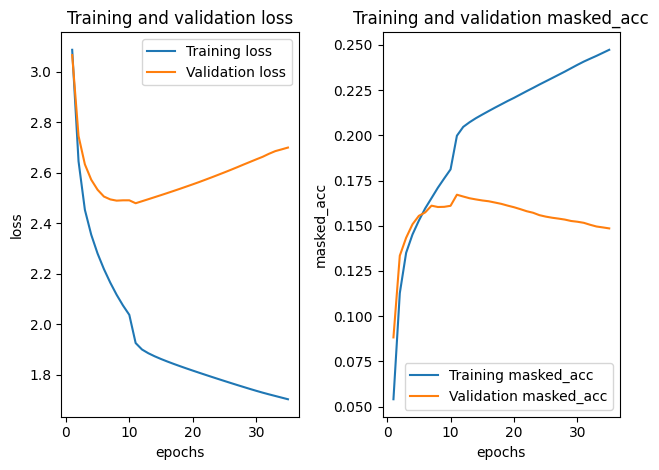

2.4797556400299072 The best number of epocs for the validation loss is 11
0.16716834902763367 The best number of epocs for the validation accuracy is 11


In [24]:
# Functional API - 2 layers, norm_epsilon 1e-9
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-9
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-07 23:40:00)

- `NORMALIZE_FIRST = True`
- `NUM_ENCODERS = 2`
- `NUM_DECODERS = 2`
- `layer_norm_epsilon=1e-06`

#### Result

- LAYER_NORM_EPSILON got 1/10 smaller, but almost nothing changed.

[<TransformerEncoder name=transformer_encoder_4, built=False>,
 <TransformerEncoder name=transformer_encoder_5, built=False>]
[<TransformerDecoder name=transformer_decoder_4, built=False>,
 <TransformerDecoder name=transformer_decoder_5, built=False>]
Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 173s 330ms/step - loss: 3.3900 - masked_acc: 0.0439 - val_loss: 3.0563 - val_masked_acc: 0.0952
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 307ms/step - loss: 2.7058 - masked_acc: 0.1032 - val_loss: 2.7461 - val_masked_acc: 0.1336
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 314ms/step - loss: 2.4802 - masked_acc: 0.1329 - val_loss: 2.6345 - val_masked_acc: 0.1430
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 323ms/step - loss: 2.3706 - masked_acc: 0.1426 - val_loss: 2.5792 - val_masked_acc: 0.1488
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 2788s 6s/step - loss: 2.2915 - masked_acc: 0.1516 - val_loss: 2.5315 - val_masked_acc: 0.1550
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 315ms/step - loss: 2.2218

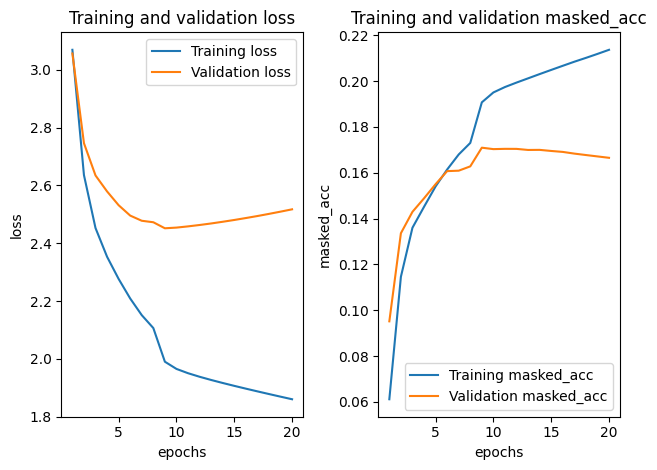

2.451754570007324 The best number of epocs for the validation loss is 9
0.17096149921417236 The best number of epocs for the validation accuracy is 9


In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-6
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 8,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

[<TransformerEncoder name=transformer_encoder_2, built=False>,
 <TransformerEncoder name=transformer_encoder_3, built=False>]
[<TransformerDecoder name=transformer_decoder_2, built=False>,
 <TransformerDecoder name=transformer_decoder_3, built=False>]
Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 167s 317ms/step - loss: 3.3891 - masked_acc: 0.0338 - val_loss: 3.0401 - val_masked_acc: 0.0956
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 134s 298ms/step - loss: 2.7034 - masked_acc: 0.1024 - val_loss: 2.7472 - val_masked_acc: 0.1334
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 295ms/step - loss: 2.4812 - masked_acc: 0.1316 - val_loss: 2.6267 - val_masked_acc: 0.1439
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 134s 298ms/step - loss: 2.3654 - masked_acc: 0.1433 - val_loss: 2.5763 - val_masked_acc: 0.1510
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 295ms/step - loss: 2.2940 - masked_acc: 0.1513 - val_loss: 2.5394 - val_masked_acc: 0.1547
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 297ms/step - loss: 2.23

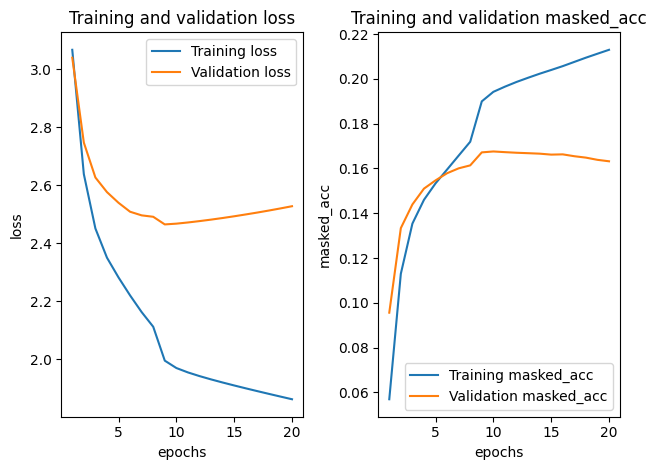

2.464806318283081 The best number of epocs for the validation loss is 9
0.1675938069820404 The best number of epocs for the validation accuracy is 10


In [20]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 8,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict

In [19]:
SENTENCES = [
    """By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to be interesting' Trio: Westwood, his son and Poulter were snapped in this selfie at Royal Liverpool during practice . The team: Westwood uploaded this photograph to Instagram after his son convinced him to join . Giving in: Westwood said his son convinced him to join the social networking website . The Open starts on Thursday, and sees Poulter tee off at 9.37am with Westwood at 2.38pm. The latter, though, may be under added pressure after Europe's Ryder Cup captain Paul McGinley urged the 41-year-old to up his game in Liverpool. 'We all know Lee has the pedigree,' said McGinley. 'If you look back at the Ryder Cup since 1997, he has been the one constant pillar of all our success during that time. 'I'm a huge fan, and I'm certainly not looking to rip up the template. But I have to justify every decision I make, so he has to show me some form.' Hit and miss: Europe's Ryder Cup captain Paul McGinley says Westwood must 'show me some form' 6.25am: David Howell (ENG), David Duval (USA), Robert Krlsson (SWE) 6.36am: Dawie van der Walt (RSA), Cameron Tringale (USA), Masanori Kobayashi (JPN) 6.47am: Chris Wood (ENG), Matt Jones (AUS), Bernd Wiesberger (AUT) 6.58am: Erik Compton (USA), Kim Hyung-sung (KOR), Marc Leishman (AUS) 7.09am: Koumei Oda (JPN), Ben Martin (USA), Anirban Lahiri (IND) 7.20am: Kiradech Aphibarnrat (THA), Brooks Koepka (USA), Edoardo Molinari (ITA) 7.31am: Branden Grace (RSA), Freddie Jacobson (SWE), Ashley Chesters (ENG) 7.42am: Justin Leonard (USA), Ben Curtis (USA), Paul Lawrie (SCO) 7.53am: Francesco Molinari (ITA), Ryan Moore (USA), Thorbjorn Olesen (DEN) 8.04am: Matteo Manassero (ITA), Bradley Neil (SCO), Mikko Ilonen (FIN) 8.15am: Thomas Bjorn (DEN), Patrick Reed (USA), Stewart Cink (USA) 8.26am: Ben Watson (USA), Jim Furyk (USA), Darren Clarke (NIR) 8.37am: Luke Donald (ENG), Rickie Fowler (USA), Sergio Garcia (ESP) 8.53am: Harris English (USA), Paul Casey (ENG), Matt Every (USA) 9.04am: Tiger Woods (USA), Angel Cabera (ARG), Henrik Stenson (SWE) 9.15am: Charl Schwartzel (RSA), Padraig Harrington (IRL), KJ Choi (KOR) 9.26am: Rory McIlroy (NIR), Hideki Matsuyama (JPN), Jordan Spieth (USA) 9.37am: Ian Poulter (ENG), Dustin Johnson (USA), Jimmy Walker (USA) 9.48am: Graeme McDowell (NIR), Matt Kuchar (USA), Louis Oosthuizen (RSA) 9.59am: Stephen Gallacher (SCO), Hunter Mahan (USA), Victor Dubuisson (FRA) 10.10am: Sir Nick Faldo (ENG), Todd Hamilton (USA), Mark Calcavecchia (USA) 10.21am: Ryan Palmer (USA), Brett Rumford (AUS), Tomohiro Kondo (JPN) 10.32am: John Singleton (ENG), Peter UIhlein (USA), Marc Warren (SCO) 10.43am: Paul McKechnie (SCO), Kristoffer Broberg (SWE), Juvic Pagunsan (PHI) 10.54am: Rhein Gibon (AUS), Brian Harman (USA), Kim Hyung-tae (KOR), . 11.05am: Chris Hanson (ENG), Oscar Floren (SWE), Yoshinobu Tsukada (JPN) 11.26am: James McLeary (SCO), Matthew Southgate (ENG), Hiroshi Iwata (JPN) 11.37am: Roberto Castro (USA), Victor Riu (FRA), Tyrrell Hatton (ENG) 11.48am: Jang Dong-kyu (KOR), Nick Watney (USA), Shawn Stefani (USA) 11.59am: D A Points (USA), Ye Yang (KOR), Brendan Steele (USA) 12.10pm: Scott Stallings (USA), Pablo Larrazabal (ESP), Bryden Macpherson (AUS) 12.21pm: George Coetzee (RSA), Charley Hoffman (USA), Michael Hoey (NIR) 12.32pm: Kevin Streelman (USA), Brendon de Jonge (ZIM), Brendon Todd (USA) 12.43pm: Gary Woodland (USA), Sandy Lyle (SCO), Kevin Stadler (USA) 12.54pm: Brandt Snedeker (USA), Graham Delaet (CAN), Pan Cheng-tsung (TPE) 1.05pm: Boo Weekley (USA), Danny Willett (ENG), Wu Ashun (CHN) 1.16pm: JB Holmes (USA), Jonas Blixt (SWE), Chris Kirk (USA) 1.27pm: Miguel Angel Jiminez (ESP), Bill Haas (USA), Thongchai Jaidee (THA) 1.38pm: Martin Kaymer (GER), Jason Day (AUS), Zach Johnson (USA) 1.54pm: Webb Simpson (USA), Jamie Donaldson (WAL), Yusaku Miyazato (JPN) 2.05pm: Phil Mickelson (USA), Ernie Els (RSA), Bubba Watson (USA) 2.16pm: Gonzalo Fernandez-Castano (ESP), Russell Henley (USA), Billy Horschel (USA) 2.27pm: Adam Scott (AUS), Justin Rose (ENG), Jason Dufne (USA) 2.38pm: Ryo Ishikawa (JPN), Lee Westwood (ENG), Keegan Bradley (USA) 2.49pm: Kevin Na (USA), Joost Luiten (HOL), John Senden (AUS) 3.00pm: John Daly (USA), Tommy Fleetwood (ENG), Ross Fisher (ENG) 3.11pm: Mark Wiebe (USA), Rafael Cabrera-bello (ESP), Paul Dunne (IRL) 3.22pm: Oliver Fisher (ENG), Chesson Hadley (USA), Shane Lowry (IRL) 3.33pm: George McNeill (USA), Richard Sterne (RSA), Chris Stroud (USA) 3.44pm: Gregory Bourdy (FRA), Jin Jeong (KOR), Matthew Baldwin (ENG) 3.55pm: Justin Walters (RSA), Rhys Enoch (WAL), Billy Hurley III (USA) 4.06pm: Christoper Rodgers (ENG), Scott Jamieson (SCO), An Byeong-hun (KOR)""",
    """The Catholic Church has taken a 'step in the right direction' by holding talks on how to provide better spiritual care to homosexual members, gay rights activists said today. Following Pope Francis' famous 'Who am I to judge?' comment on homosexuality last year,\xc2\xa0bishops have repeatedly spoken of the need to change the church's language towards gays from words of moral condemnation and judgment, to words of welcome and respect. Now\xc2\xa0for the first time a Vatican meeting is discussing gay and lesbian issues within the Church - a move described as 'a crack in the ice that we have been waiting for, for a very long time' by the Catholic gay rights group\xc2\xa0New Ways Ministry. Scroll down for video . Discussions: Pope Francis talks to prelates as he arrives for a morning session of a two-week synod on family issues, at the Vatican this morning. Among the issues the synod will debate will be how to provide better spiritual care to homosexual members . New era: The decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis (pictured today) Despite their apparent softening on the issue, the Vatican's top canon lawyer was keen to make clear that the ongoing discussions will not focus on changing the Church's\xc2\xa0doctrine on homosexuality, nor will it lead to an endorsement of gay marriage or even gay unions. But the decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis. On the other hand the last pope, Benedict XVI, penned some of the modern Catholic Church's key documents opposing homosexuality\xc2\xa0when he was head the Vatican's orthodoxy office in the 1980s. 'I think what we're seeing is a crack in the ice that we have been waiting for, for a very long time,' said Francis DeBernardo, executive director of New Ways Ministry. 'It's a sign of a first step.' Church teaching holds that gay acts are 'intrinsically disordered,' sinful and a 'serious depravity,' and that homosexual inclination is 'objectively disordered.'\xc2\xa0At the same time, it says homosexuals themselves must be treated with respect and compassion and not suffer discrimination. 'I know scores of people who have left the Catholic Church because of those words,' DeBernardo said. Progressive: The Vatican synod is discussing gay and lesbian issues within the Church for the first time. The move has been described as 'a crack in the ice' by the Catholic gay rights group New Ways Ministry . Emeritus Pope Benedict XVI penned some of the Vatican's key documents on gays when he headed the Vatican's orthodoxy office; a 1986 letter of his to bishops on providing pastoral care to gays insisted that any church program must clearly state 'that homosexual activity is immoral.' His 2003 document opposing same-sex unions made clear that 'there are absolutely no grounds for considering homosexual unions to be in any way similar or even remotely analogous to God's plan for marriage and family.' The Vatican's top canon lawyer, Cardinal Francesco Coccopalmerio, yesterday said that the Catholic Church would 'never' accept gay marriage or even bless a gay union. Despite that unbending position, there's no doubting that a shift in tone has occurred. Michael Brinkschroeder, co-president of the European Forum of LGBT Christian Groups, said \xc2\xa0it was clear that the synod won't change doctrine, but that the 'Francis effect' appeared to be trickling down to local bishops. Many had 'lost their fear' and are freer now to engage in dialogue with gays in a way they couldn't under the last two popes, he said. 'With Benedict vanished from the scene, Francis has given signals for bishops to start pastoral work and dialogue,' he said. Welcome: Vatican Swiss Guards  salute Pope Francis as he arrives for the synod earlier in the week . Pope\xc2\xa0Francis famously said 'Who am I to judge?' when asked in 2013 about rumors that a top priestly adviser had a gay lover. DeBernardo, of New Ways Ministry, said the next step is for gays to be at the table offering their testimony to bishops. No openly gay Catholics have addressed the closed-door synod, but two Catholic heterosexual couples have spoken about experiences of devout Catholics welcoming gays or trying to provide pastoral care for them. He said he was 'euphoric' that some bishops had said language such as 'intrinsically disordered' was wholly ineffective in bringing people closer to the church. Not so fast, say conservative Catholics. Hard-line Cardinal Raymond Burke, who heads the Vatican's high court, insisted that gay sex was and will remain 'intrinsically disordered' and children must be protected from thinking otherwise. He was responding to testimony from an Australian Catholic couple who told the synod about friends who welcomed their gay son and his partner to a Christmas party. 'That particular form of relationship should not be imposed upon family members, and especially upon impressionable children,' Burke told the conservative LifeSiteNews. 'And I urge parents or grandparents - whoever it may be - to be very, very prudent in this matter and not to scandalize their children or grandchildren.""",
    """Vice President Dick Cheney will serve as acting president briefly Saturday while President Bush is anesthetized for a routine colonoscopy, White House spokesman Tony Snow said Friday. Bush is scheduled to have the medical procedure, expected to take about 2 1/2 hours, at the presidential retreat at Camp David, Maryland, Snow said. Bush's last colonoscopy was in June 2002, and no abnormalities were found, Snow said. The president's doctor had recommended a repeat procedure in about five years. The procedure will be supervised by Dr. Richard Tubb and conducted by a multidisciplinary team from the National Naval Medical Center in Bethesda, Maryland, Snow said. A colonoscopy is the most sensitive test for colon cancer, rectal cancer and polyps, small clumps of cells that can become cancerous, according to the Mayo Clinic. Small polyps may be removed during the procedure. Snow said that was the case when Bush had colonoscopies before becoming president. Snow himself is undergoing chemotherapy for cancer that began in his colon and spread to his liver. Snow told reporters he had a chemo session scheduled later Friday. Watch Snow talk about Bush's procedure and his own colon cancer » . "The president wants to encourage everybody to use surveillance," Snow said. The American Cancer Society recommends that people without high-risk factors or symptoms begin getting screened for signs of colorectal cancer at age 50. E-mail to a friend ."""
]
predict_model(
    model=model,
    examples=SENTENCES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)
print("")

ORIGINAL SENTENCE:  By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to 

***

## Note

- training-lossは減少傾向、training-accは上昇傾向、valは逆の傾向が見られるのでoverfit傾向にある
- networkのhead,dim,layersを増やして全体の数値が向上するのかみたい
- 逆に数値を減らして全体の数値が劣化することを示しても良いかもしれない（しかし高頻度の語彙があるので下限のborderで止まる可能性もある）
- 翻訳モデルで検証することも可能

The network size seemingly causes this problem. In the larger size neural network of translation model, let us verify.

2024-07-03 13:36:03.785775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


build is called ((None, 2137), (None, 256))
Epoch 1/10


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefo

1795/1795 ━━━━━━━━━━━━━━━━━━━━ 921s 508ms/step - loss: 6.7884 - masked_acc: 0.1065 - val_loss: 5.6804 - val_masked_acc: 0.1558
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 923s 512ms/step - loss: 5.6005 - masked_acc: 0.1585 - val_loss: 5.4289 - val_masked_acc: 0.1668
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 922s 511ms/step - loss: 5.2347 - masked_acc: 0.1735 - val_loss: 5.3316 - val_masked_acc: 0.1749
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 920s 510ms/step - loss: 4.9996 - masked_acc: 0.1838 - val_loss: 5.2993 - val_masked_acc: 0.1786
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 934s 518ms/step - loss: 4.8259 - masked_acc: 0.1929 - val_loss: 5.2987 - val_masked_acc: 0.1804
Epoch 6/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 1041s 578ms/step - loss: 4.6864 - masked_acc: 0.2015 - val_loss: 5.3242 - val_masked_acc: 0.1808
Epoch 7/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 1017s 564ms/step - loss: 4.5682 - masked_acc: 0.2098 - val_loss: 5.3628 - val_masked_acc: 0.1805
Epoch 8/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 9

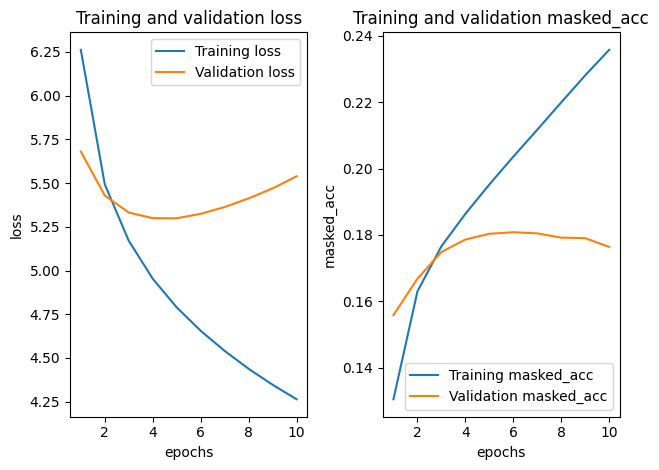

5.298709869384766 The best number of epocs for the validation loss is 5
0.1808236986398697 The best number of epocs for the validation accuracy is 6


In [ ]:
# development params to pass running
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 16
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMEDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [15]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

build is called [[None, 2137], [None, 256]]


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream l

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict

***
## Larger model

### Note

- The validation loss value got slightly larger.
- The validation accuracy got slightly smaller.
- The loss and accuracy path have not changed at all.

2024-07-03 18:44:51.608721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


build is called ((None, 2137), (None, 256))
Epoch 1/10


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefo

1795/1795 ━━━━━━━━━━━━━━━━━━━━ 8087s 4s/step - loss: 6.7994 - masked_acc: 0.1045 - val_loss: 5.7279 - val_masked_acc: 0.1548
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5346s 3s/step - loss: 5.6556 - masked_acc: 0.1593 - val_loss: 5.4593 - val_masked_acc: 0.1693
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5339s 3s/step - loss: 5.2970 - masked_acc: 0.1745 - val_loss: 5.3666 - val_masked_acc: 0.1744
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5318s 3s/step - loss: 5.0724 - masked_acc: 0.1846 - val_loss: 5.3498 - val_masked_acc: 0.1766
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5045s 3s/step - loss: 4.9200 - masked_acc: 0.1921 - val_loss: 5.3655 - val_masked_acc: 0.1772
Epoch 6/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 4998s 3s/step - loss: 4.8088 - masked_acc: 0.1983 - val_loss: 5.3888 - val_masked_acc: 0.1771
Epoch 7/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 4970s 3s/step - loss: 4.7210 - masked_acc: 0.2033 - val_loss: 5.4101 - val_masked_acc: 0.1773
Epoch 8/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 4950s 3s/step - l

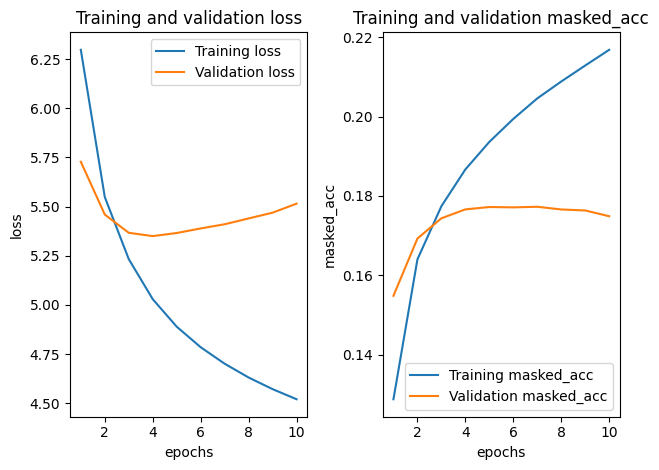

5.349842548370361 The best number of epocs for the validation loss is 4
0.17725861072540283 The best number of epocs for the validation accuracy is 7


In [18]:
# development params to improve acc
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 16
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 12
INTERMEDIATE_DIM = 1024
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [19]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

build is called [[None, 2137], [None, 256]]


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 182 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream 

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict

***
## Functional API model

### Note

Almost nothing changed.

- The shortage decoder sequence length loses correlation?
- The mask zero parameter should be False?

2024-07-04 12:36:44.057674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "transformer_encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 2137)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 2137, 64)  │  1,096,768 │ encoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 256, 64)   │    976,384 │ decoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 2137, 64)  │     81,972 │ token_and_positi… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 256, 64)   │     97,704 │ token_and_positi… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256,       │    975,000 │ transformer_deco… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,227,828 (12.31 MB)

 Trainable params: 3,227,828 (12.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefo

1795/1795 ━━━━━━━━━━━━━━━━━━━━ 932s 514ms/step - loss: 6.7873 - masked_acc: 0.1062 - val_loss: 5.6913 - val_masked_acc: 0.1554
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 3528s 2s/step - loss: 5.6113 - masked_acc: 0.1581 - val_loss: 5.4459 - val_masked_acc: 0.1666
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 912s 506ms/step - loss: 5.2509 - masked_acc: 0.1721 - val_loss: 5.3445 - val_masked_acc: 0.1732
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 912s 506ms/step - loss: 5.0165 - masked_acc: 0.1829 - val_loss: 5.3061 - val_masked_acc: 0.1777
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 920s 510ms/step - loss: 4.8443 - masked_acc: 0.1919 - val_loss: 5.3042 - val_masked_acc: 0.1795
Epoch 6/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 937s 520ms/step - loss: 4.7059 - masked_acc: 0.2002 - val_loss: 5.3228 - val_masked_acc: 0.1796
Epoch 7/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 988s 548ms/step - loss: 4.5879 - masked_acc: 0.2082 - val_loss: 5.3565 - val_masked_acc: 0.1791
Epoch 8/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 1007s

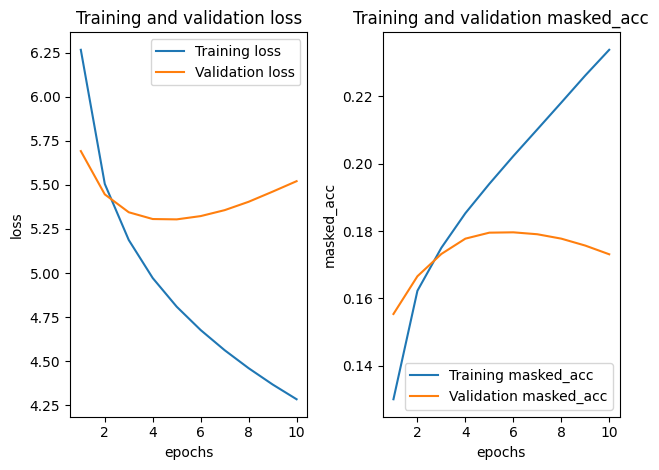

5.304164409637451 The best number of epocs for the validation loss is 5
0.17962834239006042 The best number of epocs for the validation accuracy is 6


In [24]:
# development params to pass running
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 16
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMEDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

***
# mac OS Experiments

### Note (Experiment Date: 2024-07-07 23:40:00)

- `NORMALIZE_FIRST = True`
- `NUM_ENCODERS = 2`
- `NUM_DECODERS = 2`

#### Result

It got stuck around 25%. Nothing has changed.

Epoch 1/20


2024-07-08 02:06:24.075696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4487/4487 ━━━━━━━━━━━━━━━━━━━━ 1367s 300ms/step - loss: 2.3829 - masked_acc: 0.1105 - val_loss: 2.2140 - val_masked_acc: 0.1843
Epoch 2/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 1333s 297ms/step - loss: 1.8886 - masked_acc: 0.1852 - val_loss: 2.1024 - val_masked_acc: 0.2031
Epoch 3/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 1331s 296ms/step - loss: 1.8057 - masked_acc: 0.2015 - val_loss: 2.0526 - val_masked_acc: 0.2131
Epoch 4/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 1323s 295ms/step - loss: 1.7642 - masked_acc: 0.2106 - val_loss: 2.0243 - val_masked_acc: 0.2197
Epoch 5/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 1330s 296ms/step - loss: 1.7352 - masked_acc: 0.2173 - val_loss: 2.0039 - val_masked_acc: 0.2241
Epoch 6/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 1333s 297ms/step - loss: 1.7128 - masked_acc: 0.2228 - val_loss: 1.9894 - val_masked_acc: 0.2274
Epoch 7/20
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 1333s 297ms/step - loss: 1.6949 - masked_acc: 0.2273 - val_loss: 1.9765 - val_masked_acc: 0.2308
Epoch 8/20
4487/4487 ━━━━━━━━━━━━━━━━━

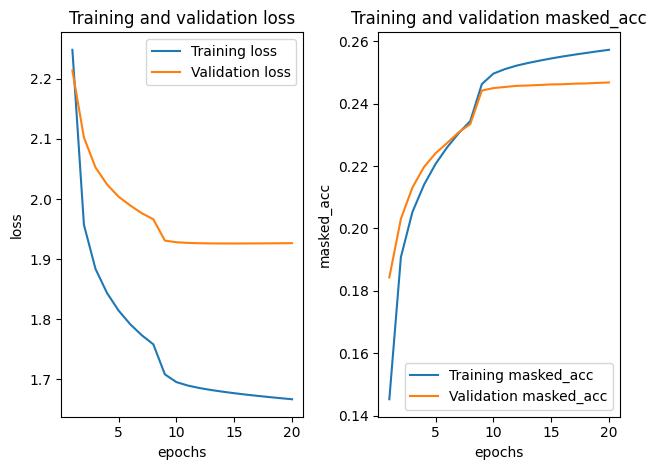

1.926040768623352 The best number of epocs for the validation loss is 15
0.2468041032552719 The best number of epocs for the validation accuracy is 20


In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 4487
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 8,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-07 03:30:00)

Comparing larger Transformer 6 layers model with Transformer 1 layer model to verify the vanishing gradient between Transformer layers.

- **100 epochs**
- **100% dataset**
- Optimizer: ExponentialWarmupSchedule
    - Learning rate: 1/10 for every 80 epoch
- Batch: 64
- Heads: 12
- Transformer intermediate dim: 2048
- Encoder sequence length: 256
- Decoder sequence length: 128

#### Result

Expectedly, it gets stuck around 26%. This result supports the experiments on SageMaker at 2024-07-06 23:55:00, and shows almost same limit. That is, there exists a limit, which is the 24% to 26% accuracy, in the single Transformer layer model.

At the same time, if trained enough, the result indicates that the model is possible to obtain the generalization as the validation loss and accuracy got close to the training ones.

In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 4487
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 40,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Epoch 1/100


2024-07-07 03:45:26.102404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4487/4487 ━━━━━━━━━━━━━━━━━━━━ 967s 213ms/step - loss: 2.4860 - masked_acc: 0.1096 - val_loss: 2.1428 - val_masked_acc: 0.2031
Epoch 2/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 957s 213ms/step - loss: 1.8346 - masked_acc: 0.2016 - val_loss: 2.0338 - val_masked_acc: 0.2221
Epoch 3/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 961s 214ms/step - loss: 1.7502 - masked_acc: 0.2174 - val_loss: 2.0004 - val_masked_acc: 0.2284
Epoch 4/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 925s 206ms/step - loss: 1.7154 - masked_acc: 0.2247 - val_loss: 1.9843 - val_masked_acc: 0.2318
Epoch 5/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 929s 207ms/step - loss: 1.6951 - masked_acc: 0.2292 - val_loss: 1.9744 - val_masked_acc: 0.2341
Epoch 6/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 927s 206ms/step - loss: 1.6811 - masked_acc: 0.2323 - val_loss: 1.9689 - val_masked_acc: 0.2355
Epoch 7/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 924s 206ms/step - loss: 1.6708 - masked_acc: 0.2348 - val_loss: 1.9649 - val_masked_acc: 0.2369
Epoch 8/100
4487/4487 ━━━━━━━━━━━━━━━━━

### Note (Experiment Date: 2024-07-07 01:00:00)

- **160 epochs**
- 10% dataset
- Optimizer: ExponentialWarmupSchedule
    - Learning rate: 1/10 for every 50 epoch
- Batch: 64
- Heads: 12
- Transformer intermediate dim: 2048
- Encoder sequence length: 128
- Decoder sequence length: 64

#### Result

- Around 55%, it got stuck.
- 1/10 for every 50 epoch is effective.
    - The learning rate gets smaller over each time.


Epoch 1/160
449/449 ━━━━━━━━━━━━━━━━━━━━ 75s 128ms/step - loss: 6.7862 - masked_acc: 0.0352 - val_loss: 5.7580 - val_masked_acc: 0.0652
Epoch 2/160
449/449 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - loss: 5.2029 - masked_acc: 0.0775 - val_loss: 5.1448 - val_masked_acc: 0.1327
Epoch 3/160
449/449 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - loss: 4.6711 - masked_acc: 0.1343 - val_loss: 4.8049 - val_masked_acc: 0.1507
Epoch 4/160
449/449 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - loss: 4.3636 - masked_acc: 0.1528 - val_loss: 4.6382 - val_masked_acc: 0.1584
Epoch 5/160
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - loss: 4.1548 - masked_acc: 0.1640 - val_loss: 4.5146 - val_masked_acc: 0.1658
Epoch 6/160
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - loss: 3.9750 - masked_acc: 0.1752 - val_loss: 4.4350 - val_masked_acc: 0.1716
Epoch 7/160
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - loss: 3.8220 - masked_acc: 0.1864 - val_loss: 4.3935 - val_masked_acc: 0.1774
Epoch 8/160
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 118

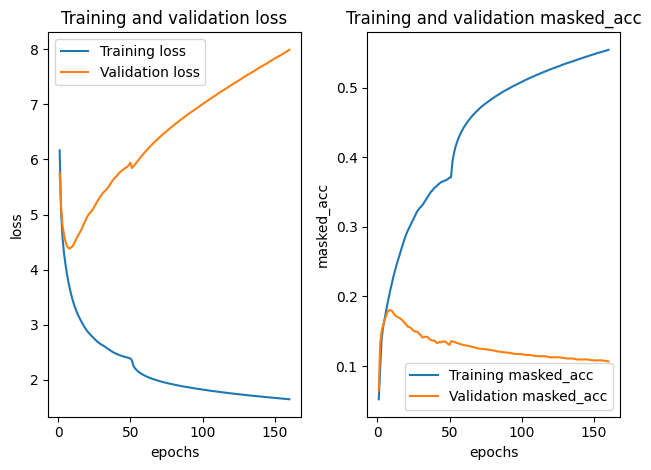

4.382027626037598 The best number of epocs for the validation loss is 8
0.1800994873046875 The best number of epocs for the validation accuracy is 9


In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 160
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 64 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 50,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-06 23:00:00)

- 10% dataset
- Optimizer: ExponentialWarmupSchedule
    - **Learning rate: 1/10 for every 50 epoch**
- Batch: 64
- Heads: 8 to 12
- Transformer intermediate dim: 1024 to 2048
- Encoder sequence length: 128
- Decoder sequence length: 64

#### Result

- masked_acc: 0.3864 to 0.4376

The number of epochs might not be sufficient.

Epoch 1/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 72s 130ms/step - loss: 6.7833 - masked_acc: 0.0373 - val_loss: 5.7613 - val_masked_acc: 0.0652
Epoch 2/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - loss: 5.2104 - masked_acc: 0.0773 - val_loss: 5.1549 - val_masked_acc: 0.1322
Epoch 3/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - loss: 4.6787 - masked_acc: 0.1345 - val_loss: 4.8128 - val_masked_acc: 0.1500
Epoch 4/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 4.3688 - masked_acc: 0.1531 - val_loss: 4.6387 - val_masked_acc: 0.1581
Epoch 5/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - loss: 4.1549 - masked_acc: 0.1639 - val_loss: 4.5164 - val_masked_acc: 0.1656
Epoch 6/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 54s 120ms/step - loss: 3.9732 - masked_acc: 0.1749 - val_loss: 4.4356 - val_masked_acc: 0.1718
Epoch 7/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - loss: 3.8157 - masked_acc: 0.1866 - val_loss: 4.3974 - val_masked_acc: 0.1767
Epoch 8/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 54s 120ms/step 

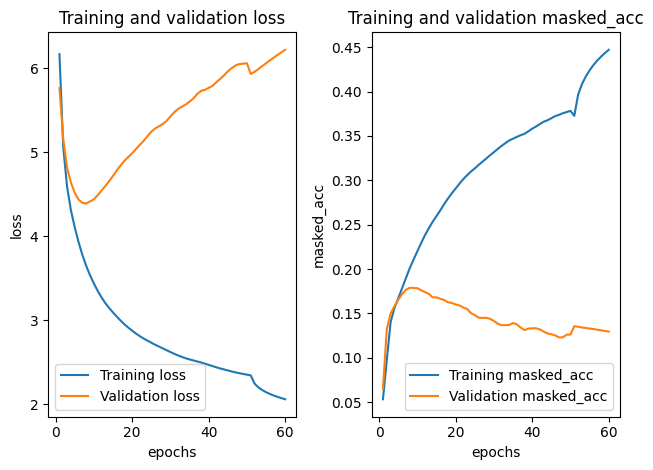

4.389637470245361 The best number of epocs for the validation loss is 8
0.17890752851963043 The best number of epocs for the validation accuracy is 8


In [ ]:
# 10% dataset
# ExponentialWarmupSchedule
# batch: 64, num_heads: 12, transformer_intermediate_dim: 2048
# encoder sequence: 128
# decoder sequence: 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 60
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 64 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 50,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-06 23:00:00)

- **10% dataset**
- Optimizer: ExponentialWarmupSchedule
- Batch: 64
- Heads: 12
- Transformer intermediate dim: 2048
- Encoder sequence length: 128
- Decoder sequence length: 64

#### Result

- masked_acc: 0.5714 to 0.3864
- Got stuck around 50th epoch

The number of epochs might not be sufficient.

Epoch 1/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 69s 124ms/step - loss: 6.7779 - masked_acc: 0.0375 - val_loss: 5.7613 - val_masked_acc: 0.0652
Epoch 2/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 52s 115ms/step - loss: 5.2154 - masked_acc: 0.0756 - val_loss: 5.1597 - val_masked_acc: 0.1314
Epoch 3/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 51s 115ms/step - loss: 4.6832 - masked_acc: 0.1346 - val_loss: 4.8049 - val_masked_acc: 0.1507
Epoch 4/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 51s 115ms/step - loss: 4.3624 - masked_acc: 0.1535 - val_loss: 4.6321 - val_masked_acc: 0.1579
Epoch 5/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 51s 114ms/step - loss: 4.1467 - masked_acc: 0.1647 - val_loss: 4.5095 - val_masked_acc: 0.1653
Epoch 6/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 51s 114ms/step - loss: 3.9631 - masked_acc: 0.1763 - val_loss: 4.4281 - val_masked_acc: 0.1715
Epoch 7/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - loss: 3.8058 - masked_acc: 0.1879 - val_loss: 4.3875 - val_masked_acc: 0.1767
Epoch 8/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step 

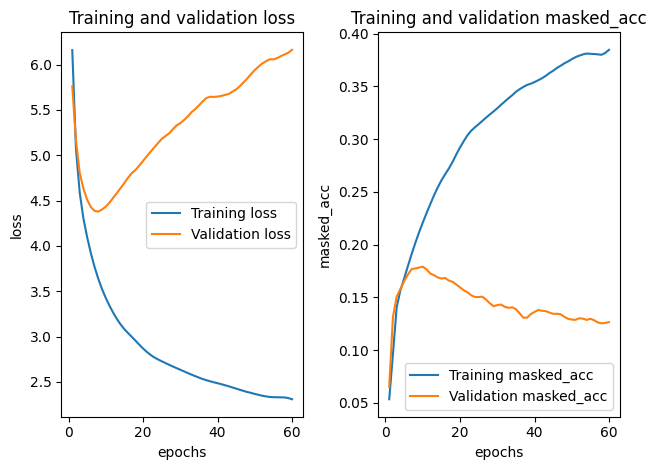

4.3791303634643555 The best number of epocs for the validation loss is 8
0.17915146052837372 The best number of epocs for the validation accuracy is 10


In [ ]:
# batch: 64, num_heads: 12, transformer_intermediate_dim: 2048
# encoder sequence: 128
# decoder sequence: 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 60
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 64 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 150,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-06 23:00:00)

- 5% dataset
- Optimizer: ExponentialWarmupSchedule
- Batch: 64
- Heads: 8 to 12
- Transformer intermediate dim: 1024 to 2048
- Encoder sequence length: 128
- Decoder sequence length: 64

The number of epochs might not be sufficient.

#### Result

- ExponentialWarmupSchedule improves the performance and the speed.

Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - loss: 7.1506 - masked_acc: 0.0235 - val_loss: 6.5753 - val_masked_acc: 0.0669
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - loss: 5.7403 - masked_acc: 0.0600 - val_loss: 5.7901 - val_masked_acc: 0.0669
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - loss: 5.3170 - masked_acc: 0.0643 - val_loss: 5.4734 - val_masked_acc: 0.1106
Epoch 4/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - loss: 4.9848 - masked_acc: 0.1144 - val_loss: 5.1734 - val_masked_acc: 0.1320
Epoch 5/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 114ms/step - loss: 4.7018 - masked_acc: 0.1357 - val_loss: 4.9968 - val_masked_acc: 0.1423
Epoch 6/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - loss: 4.4830 - masked_acc: 0.1511 - val_loss: 4.8737 - val_masked_acc: 0.1500
Epoch 7/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 114ms/step - loss: 4.3064 - masked_acc: 0.1619 - val_loss: 4.8224 - val_masked_acc: 0.1512
Epoch 8/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step 

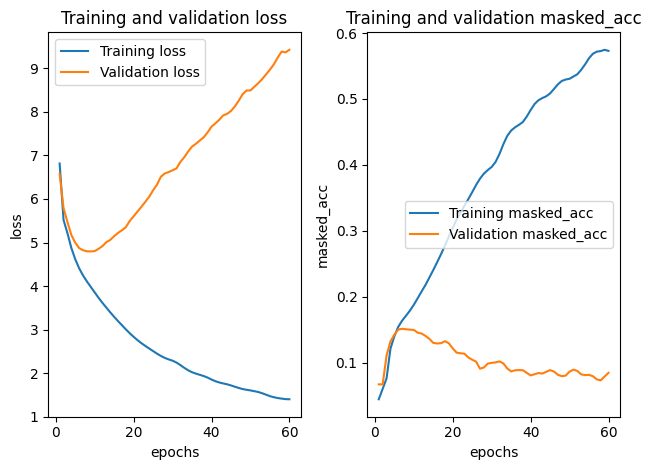

4.79620885848999 The best number of epocs for the validation loss is 9
0.15119780600070953 The best number of epocs for the validation accuracy is 7


In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 60
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 64 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 225
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 150,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-06 18:00:00)

- 5% dataset
- batch: 16
- num_heads: 8 to 12
- transformer_intermediate_dim: 1024 to 2048
- optimizer: RMSprop to AdamW

#### Result

- The number of epochs might not be sufficient.
- AdamW is better than RMSprop


Epoch 1/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 73s 68ms/step - loss: 5.4702 - masked_acc: 0.0822 - val_loss: 5.0165 - val_masked_acc: 0.1385
Epoch 2/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 59s 66ms/step - loss: 4.5353 - masked_acc: 0.1415 - val_loss: 4.7839 - val_masked_acc: 0.1485
Epoch 3/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - loss: 4.2201 - masked_acc: 0.1577 - val_loss: 4.7307 - val_masked_acc: 0.1514
Epoch 4/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 59s 66ms/step - loss: 4.0041 - masked_acc: 0.1684 - val_loss: 4.7346 - val_masked_acc: 0.1537
Epoch 5/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - loss: 3.8364 - masked_acc: 0.1776 - val_loss: 4.7604 - val_masked_acc: 0.1542
Epoch 6/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - loss: 3.7016 - masked_acc: 0.1862 - val_loss: 4.7936 - val_masked_acc: 0.1549
Epoch 7/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - loss: 3.5908 - masked_acc: 0.1945 - val_loss: 4.8434 - val_masked_acc: 0.1551
Epoch 8/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - loss: 

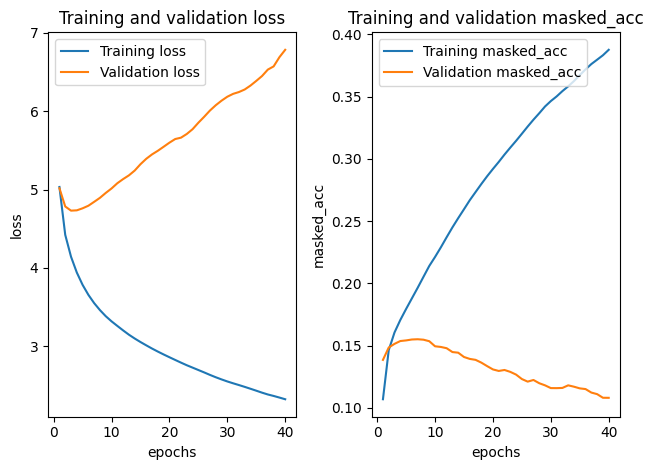

4.730709552764893 The best number of epocs for the validation loss is 3
0.15512335300445557 The best number of epocs for the validation accuracy is 7


In [ ]:
# 5% dataset
# AdamW
# batch: 16, num_heads: 8, transformer_intermediate_dim: 1024
# encoder sequence: 128
# decoder sequence: 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 40
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 64 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 16
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-06 17:00:00)

- 5% dataset
- batch: 16
- num_heads: 8 to 12
- transformer_intermediate_dim: 1024 to 2048

The number of epochs might not be sufficient.

Epoch 1/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - loss: 5.5761 - masked_acc: 0.0753 - val_loss: 5.1867 - val_masked_acc: 0.1302
Epoch 2/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - loss: 4.7489 - masked_acc: 0.1312 - val_loss: 4.9695 - val_masked_acc: 0.1422
Epoch 3/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 4.5082 - masked_acc: 0.1470 - val_loss: 4.8567 - val_masked_acc: 0.1487
Epoch 4/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - loss: 4.3530 - masked_acc: 0.1562 - val_loss: 4.8202 - val_masked_acc: 0.1518
Epoch 5/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 4.2423 - masked_acc: 0.1632 - val_loss: 4.8005 - val_masked_acc: 0.1530
Epoch 6/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - loss: 4.1568 - masked_acc: 0.1699 - val_loss: 4.8049 - val_masked_acc: 0.1527
Epoch 7/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - loss: 4.0888 - masked_acc: 0.1760 - val_loss: 4.8038 - val_masked_acc: 0.1556
Epoch 8/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - loss: 

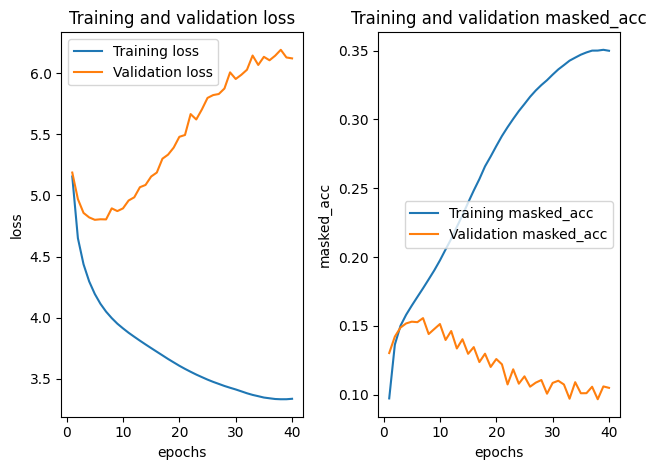

4.800478935241699 The best number of epocs for the validation loss is 5
0.1556292027235031 The best number of epocs for the validation accuracy is 7


In [ ]:
# 5% dataset
# batch: 16, num_heads: 8, transformer_intermediate_dim: 1024
# encoder sequence: 128
# decoder sequence: 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 40
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 64 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 16
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
optimizer = keras.optimizers.RMSprop(
    learning_rate=learning_rate,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-06 17:00:00)

- 5% dataset
- batch: 16
- num_heads: 8
- transformer_intermediate_dim: 1024

The number of epochs might not be sufficient.

Epoch 1/40


2024-07-06 17:38:30.825685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


898/898 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - loss: 5.5788 - masked_acc: 0.0744 - val_loss: 5.1858 - val_masked_acc: 0.1325
Epoch 2/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - loss: 4.7437 - masked_acc: 0.1317 - val_loss: 4.9524 - val_masked_acc: 0.1447
Epoch 3/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - loss: 4.4991 - masked_acc: 0.1477 - val_loss: 4.8481 - val_masked_acc: 0.1509
Epoch 4/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - loss: 4.3473 - masked_acc: 0.1566 - val_loss: 4.8141 - val_masked_acc: 0.1525
Epoch 5/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 4.2384 - masked_acc: 0.1637 - val_loss: 4.8022 - val_masked_acc: 0.1531
Epoch 6/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 4.1543 - masked_acc: 0.1707 - val_loss: 4.8072 - val_masked_acc: 0.1542
Epoch 7/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - loss: 4.0856 - masked_acc: 0.1773 - val_loss: 4.8631 - val_masked_acc: 0.1486
Epoch 8/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 4.0271 - ma

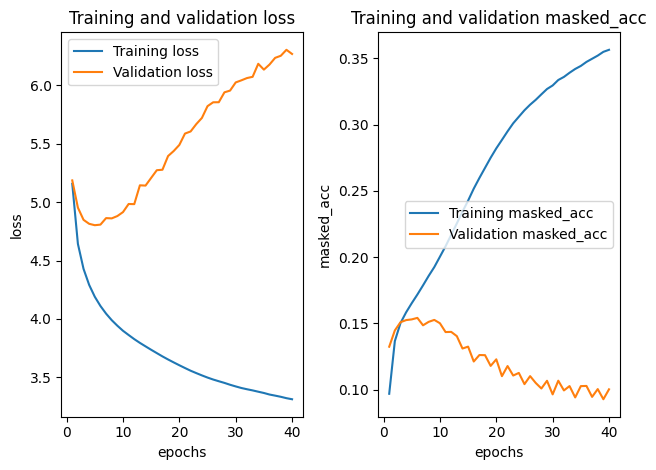

4.802222728729248 The best number of epocs for the validation loss is 5
0.15422193706035614 The best number of epocs for the validation accuracy is 6


In [ ]:
# 5% dataset
# batch: 16, num_heads: 8, transformer_intermediate_dim: 1024
# encoder sequence: 128
# decoder sequence: 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 40
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 64 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 16
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
optimizer = keras.optimizers.RMSprop(
    learning_rate=learning_rate,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-06 17:00:00)

- 10% dataset
- batch: 32
- num_heads: 8
- transformer_intermediate_dim: 1024

The number of epochs might not be sufficient.

Epoch 1/40


2024-07-06 16:34:13.319962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


898/898 ━━━━━━━━━━━━━━━━━━━━ 89s 89ms/step - loss: 3.0173 - masked_acc: 0.0759 - val_loss: 2.8251 - val_masked_acc: 0.1330
Epoch 2/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 78s 87ms/step - loss: 2.5431 - masked_acc: 0.1356 - val_loss: 2.6869 - val_masked_acc: 0.1447
Epoch 3/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - loss: 2.4108 - masked_acc: 0.1488 - val_loss: 2.6058 - val_masked_acc: 0.1534
Epoch 4/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - loss: 2.3248 - masked_acc: 0.1567 - val_loss: 2.5540 - val_masked_acc: 0.1579
Epoch 5/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - loss: 2.2603 - masked_acc: 0.1624 - val_loss: 2.5237 - val_masked_acc: 0.1610
Epoch 6/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - loss: 2.2094 - masked_acc: 0.1673 - val_loss: 2.5038 - val_masked_acc: 0.1634
Epoch 7/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - loss: 2.1676 - masked_acc: 0.1725 - val_loss: 2.4945 - val_masked_acc: 0.1658
Epoch 8/40
898/898 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - loss: 2.1338 - ma

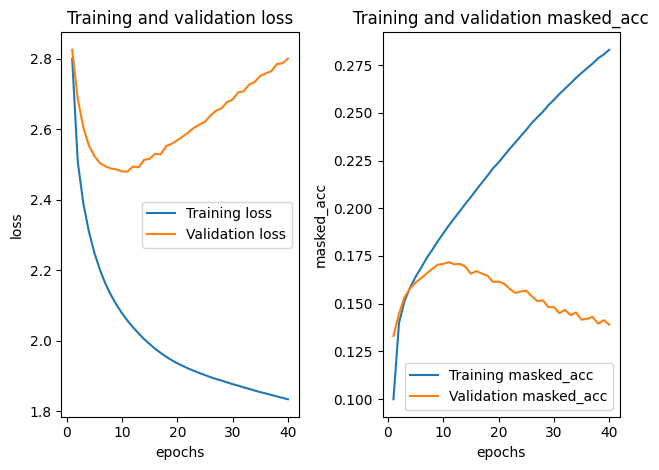

2.4796338081359863 The best number of epocs for the validation loss is 11
0.1717892587184906 The best number of epocs for the validation accuracy is 11


In [ ]:
# 10% dataset
# batch: 64, num_heads: 8, transformer_intermediate_dim: 2048
LEARNING_RATE = 0.001
NUM_EPOCHS = 40
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 32
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 0.999

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
optimizer = keras.optimizers.RMSprop(
    learning_rate=learning_rate,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-06 00:00:00)

- `keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.01,)`
- batch: 64
- num_heads: 8
- transformer_intermediate_dim: 2048

Aborted intermediately. It is so slow that it stops developing on the local machine.

In [ ]:
# batch: 64, num_heads: 8, transformer_intermediate_dim: 2048
LEARNING_RATE = 2e-5 # 0.00002
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 6
NUM_DECODERS = 6
NUM_HEADS = 8
INTERMEDIATE_DIM = 2048
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

Epoch 1/100


2024-07-06 03:26:23.460368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4487/4487 ━━━━━━━━━━━━━━━━━━━━ 2993s 653ms/step - loss: 3.0920 - masked_acc: 0.0589 - val_loss: 3.0095 - val_masked_acc: 0.0723
Epoch 2/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 2902s 646ms/step - loss: 2.5362 - masked_acc: 0.0879 - val_loss: 2.8001 - val_masked_acc: 0.1270
Epoch 3/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 2903s 647ms/step - loss: 2.3885 - masked_acc: 0.1275 - val_loss: 2.6753 - val_masked_acc: 0.1389
Epoch 4/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 2877s 641ms/step - loss: 2.2984 - masked_acc: 0.1386 - val_loss: 2.5947 - val_masked_acc: 0.1461
Epoch 5/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 2880s 641ms/step - loss: 2.2354 - masked_acc: 0.1459 - val_loss: 2.5339 - val_masked_acc: 0.1528
Epoch 6/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 2878s 641ms/step - loss: 2.1854 - masked_acc: 0.1521 - val_loss: 2.4846 - val_masked_acc: 0.1581
Epoch 7/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 2873s 640ms/step - loss: 2.1443 - masked_acc: 0.1570 - val_loss: 2.4429 - val_masked_acc: 0.1627
Epoch 8/100
4487/4487 ━━━━━━━━━━

### Note (Experiment Date: 2024-07-06 00:00:00)

- `keras.mixed_precision.set_global_policy("mixed_float16")`

Mixed-precision did not improve the performance at all. It made 2.8 times slower.

225/225 ━━━━━━━━━━━━━━━━━━━━ 206s 869ms/step - loss: 7.7639 - masked_acc: 0.0570 - val_loss: 6.3131 - val_masked_acc: 0.1228
Saving to model/summarization_model.keras
Successfully saved model to model/summarization_model.keras


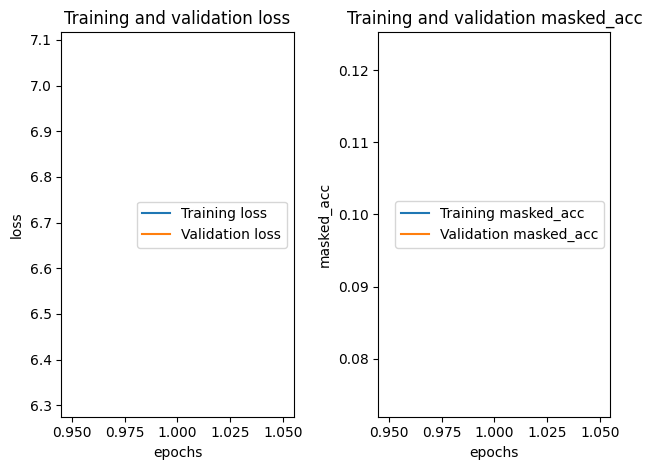

6.313060760498047 The best number of epocs for the validation loss is 1
0.12281937897205353 The best number of epocs for the validation accuracy is 1


In [ ]:
# keras.mixed_precision.set_global_policy("mixed_float16")
LEARNING_RATE = 0.001
NUM_EPOCHS = 1
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 128
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMEDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 0.99

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

### Note (Experiment Date: 2024-07-06 00:00:00)

- 1/10 dataset
- Verification if the model can overfit.
    - batch_size: 128

Epoch 1/100


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefo

225/225 ━━━━━━━━━━━━━━━━━━━━ 82s 313ms/step - loss: 7.7151 - masked_acc: 0.0593 - val_loss: 6.2452 - val_masked_acc: 0.1262
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 68s 300ms/step - loss: 6.1452 - masked_acc: 0.1308 - val_loss: 5.7981 - val_masked_acc: 0.1475
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - loss: 5.7143 - masked_acc: 0.1512 - val_loss: 5.5827 - val_masked_acc: 0.1572
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 68s 303ms/step - loss: 5.4508 - masked_acc: 0.1616 - val_loss: 5.4648 - val_masked_acc: 0.1603
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 71s 313ms/step - loss: 5.2489 - masked_acc: 0.1699 - val_loss: 5.3818 - val_masked_acc: 0.1656
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - loss: 5.0776 - masked_acc: 0.1785 - val_loss: 5.3204 - val_masked_acc: 0.1711
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 69s 307ms/step - loss: 4.9252 - masked_acc: 0.1878 - val_loss: 5.2862 - val_masked_acc: 0.1734
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 69s 306ms/step - lo

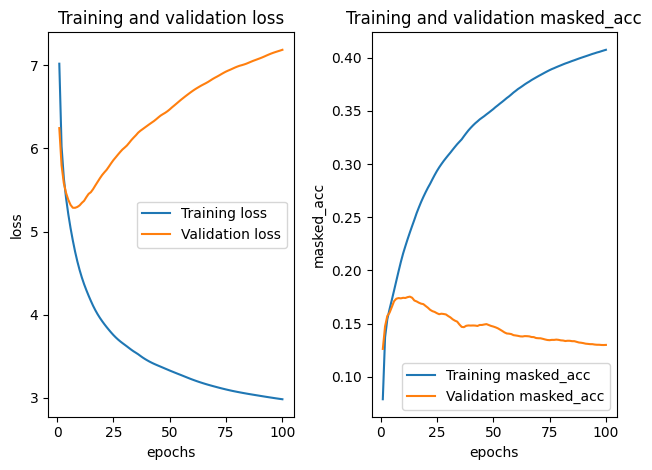

5.2859578132629395 The best number of epocs for the validation loss is 8
0.17533138394355774 The best number of epocs for the validation accuracy is 13


In [ ]:
# experiment encoder length: 256, decoder length: 128, batch: 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 128
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMEDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 0.99

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [ ]:
SENTENCES = [
    """By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to be interesting' Trio: Westwood, his son and Poulter were snapped in this selfie at Royal Liverpool during practice . The team: Westwood uploaded this photograph to Instagram after his son convinced him to join . Giving in: Westwood said his son convinced him to join the social networking website . The Open starts on Thursday, and sees Poulter tee off at 9.37am with Westwood at 2.38pm. The latter, though, may be under added pressure after Europe's Ryder Cup captain Paul McGinley urged the 41-year-old to up his game in Liverpool. 'We all know Lee has the pedigree,' said McGinley. 'If you look back at the Ryder Cup since 1997, he has been the one constant pillar of all our success during that time. 'I'm a huge fan, and I'm certainly not looking to rip up the template. But I have to justify every decision I make, so he has to show me some form.' Hit and miss: Europe's Ryder Cup captain Paul McGinley says Westwood must 'show me some form' 6.25am: David Howell (ENG), David Duval (USA), Robert Krlsson (SWE) 6.36am: Dawie van der Walt (RSA), Cameron Tringale (USA), Masanori Kobayashi (JPN) 6.47am: Chris Wood (ENG), Matt Jones (AUS), Bernd Wiesberger (AUT) 6.58am: Erik Compton (USA), Kim Hyung-sung (KOR), Marc Leishman (AUS) 7.09am: Koumei Oda (JPN), Ben Martin (USA), Anirban Lahiri (IND) 7.20am: Kiradech Aphibarnrat (THA), Brooks Koepka (USA), Edoardo Molinari (ITA) 7.31am: Branden Grace (RSA), Freddie Jacobson (SWE), Ashley Chesters (ENG) 7.42am: Justin Leonard (USA), Ben Curtis (USA), Paul Lawrie (SCO) 7.53am: Francesco Molinari (ITA), Ryan Moore (USA), Thorbjorn Olesen (DEN) 8.04am: Matteo Manassero (ITA), Bradley Neil (SCO), Mikko Ilonen (FIN) 8.15am: Thomas Bjorn (DEN), Patrick Reed (USA), Stewart Cink (USA) 8.26am: Ben Watson (USA), Jim Furyk (USA), Darren Clarke (NIR) 8.37am: Luke Donald (ENG), Rickie Fowler (USA), Sergio Garcia (ESP) 8.53am: Harris English (USA), Paul Casey (ENG), Matt Every (USA) 9.04am: Tiger Woods (USA), Angel Cabera (ARG), Henrik Stenson (SWE) 9.15am: Charl Schwartzel (RSA), Padraig Harrington (IRL), KJ Choi (KOR) 9.26am: Rory McIlroy (NIR), Hideki Matsuyama (JPN), Jordan Spieth (USA) 9.37am: Ian Poulter (ENG), Dustin Johnson (USA), Jimmy Walker (USA) 9.48am: Graeme McDowell (NIR), Matt Kuchar (USA), Louis Oosthuizen (RSA) 9.59am: Stephen Gallacher (SCO), Hunter Mahan (USA), Victor Dubuisson (FRA) 10.10am: Sir Nick Faldo (ENG), Todd Hamilton (USA), Mark Calcavecchia (USA) 10.21am: Ryan Palmer (USA), Brett Rumford (AUS), Tomohiro Kondo (JPN) 10.32am: John Singleton (ENG), Peter UIhlein (USA), Marc Warren (SCO) 10.43am: Paul McKechnie (SCO), Kristoffer Broberg (SWE), Juvic Pagunsan (PHI) 10.54am: Rhein Gibon (AUS), Brian Harman (USA), Kim Hyung-tae (KOR), . 11.05am: Chris Hanson (ENG), Oscar Floren (SWE), Yoshinobu Tsukada (JPN) 11.26am: James McLeary (SCO), Matthew Southgate (ENG), Hiroshi Iwata (JPN) 11.37am: Roberto Castro (USA), Victor Riu (FRA), Tyrrell Hatton (ENG) 11.48am: Jang Dong-kyu (KOR), Nick Watney (USA), Shawn Stefani (USA) 11.59am: D A Points (USA), Ye Yang (KOR), Brendan Steele (USA) 12.10pm: Scott Stallings (USA), Pablo Larrazabal (ESP), Bryden Macpherson (AUS) 12.21pm: George Coetzee (RSA), Charley Hoffman (USA), Michael Hoey (NIR) 12.32pm: Kevin Streelman (USA), Brendon de Jonge (ZIM), Brendon Todd (USA) 12.43pm: Gary Woodland (USA), Sandy Lyle (SCO), Kevin Stadler (USA) 12.54pm: Brandt Snedeker (USA), Graham Delaet (CAN), Pan Cheng-tsung (TPE) 1.05pm: Boo Weekley (USA), Danny Willett (ENG), Wu Ashun (CHN) 1.16pm: JB Holmes (USA), Jonas Blixt (SWE), Chris Kirk (USA) 1.27pm: Miguel Angel Jiminez (ESP), Bill Haas (USA), Thongchai Jaidee (THA) 1.38pm: Martin Kaymer (GER), Jason Day (AUS), Zach Johnson (USA) 1.54pm: Webb Simpson (USA), Jamie Donaldson (WAL), Yusaku Miyazato (JPN) 2.05pm: Phil Mickelson (USA), Ernie Els (RSA), Bubba Watson (USA) 2.16pm: Gonzalo Fernandez-Castano (ESP), Russell Henley (USA), Billy Horschel (USA) 2.27pm: Adam Scott (AUS), Justin Rose (ENG), Jason Dufne (USA) 2.38pm: Ryo Ishikawa (JPN), Lee Westwood (ENG), Keegan Bradley (USA) 2.49pm: Kevin Na (USA), Joost Luiten (HOL), John Senden (AUS) 3.00pm: John Daly (USA), Tommy Fleetwood (ENG), Ross Fisher (ENG) 3.11pm: Mark Wiebe (USA), Rafael Cabrera-bello (ESP), Paul Dunne (IRL) 3.22pm: Oliver Fisher (ENG), Chesson Hadley (USA), Shane Lowry (IRL) 3.33pm: George McNeill (USA), Richard Sterne (RSA), Chris Stroud (USA) 3.44pm: Gregory Bourdy (FRA), Jin Jeong (KOR), Matthew Baldwin (ENG) 3.55pm: Justin Walters (RSA), Rhys Enoch (WAL), Billy Hurley III (USA) 4.06pm: Christoper Rodgers (ENG), Scott Jamieson (SCO), An Byeong-hun (KOR)""",
    """The Catholic Church has taken a 'step in the right direction' by holding talks on how to provide better spiritual care to homosexual members, gay rights activists said today. Following Pope Francis' famous 'Who am I to judge?' comment on homosexuality last year,\xc2\xa0bishops have repeatedly spoken of the need to change the church's language towards gays from words of moral condemnation and judgment, to words of welcome and respect. Now\xc2\xa0for the first time a Vatican meeting is discussing gay and lesbian issues within the Church - a move described as 'a crack in the ice that we have been waiting for, for a very long time' by the Catholic gay rights group\xc2\xa0New Ways Ministry. Scroll down for video . Discussions: Pope Francis talks to prelates as he arrives for a morning session of a two-week synod on family issues, at the Vatican this morning. Among the issues the synod will debate will be how to provide better spiritual care to homosexual members . New era: The decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis (pictured today) Despite their apparent softening on the issue, the Vatican's top canon lawyer was keen to make clear that the ongoing discussions will not focus on changing the Church's\xc2\xa0doctrine on homosexuality, nor will it lead to an endorsement of gay marriage or even gay unions. But the decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis. On the other hand the last pope, Benedict XVI, penned some of the modern Catholic Church's key documents opposing homosexuality\xc2\xa0when he was head the Vatican's orthodoxy office in the 1980s. 'I think what we're seeing is a crack in the ice that we have been waiting for, for a very long time,' said Francis DeBernardo, executive director of New Ways Ministry. 'It's a sign of a first step.' Church teaching holds that gay acts are 'intrinsically disordered,' sinful and a 'serious depravity,' and that homosexual inclination is 'objectively disordered.'\xc2\xa0At the same time, it says homosexuals themselves must be treated with respect and compassion and not suffer discrimination. 'I know scores of people who have left the Catholic Church because of those words,' DeBernardo said. Progressive: The Vatican synod is discussing gay and lesbian issues within the Church for the first time. The move has been described as 'a crack in the ice' by the Catholic gay rights group New Ways Ministry . Emeritus Pope Benedict XVI penned some of the Vatican's key documents on gays when he headed the Vatican's orthodoxy office; a 1986 letter of his to bishops on providing pastoral care to gays insisted that any church program must clearly state 'that homosexual activity is immoral.' His 2003 document opposing same-sex unions made clear that 'there are absolutely no grounds for considering homosexual unions to be in any way similar or even remotely analogous to God's plan for marriage and family.' The Vatican's top canon lawyer, Cardinal Francesco Coccopalmerio, yesterday said that the Catholic Church would 'never' accept gay marriage or even bless a gay union. Despite that unbending position, there's no doubting that a shift in tone has occurred. Michael Brinkschroeder, co-president of the European Forum of LGBT Christian Groups, said \xc2\xa0it was clear that the synod won't change doctrine, but that the 'Francis effect' appeared to be trickling down to local bishops. Many had 'lost their fear' and are freer now to engage in dialogue with gays in a way they couldn't under the last two popes, he said. 'With Benedict vanished from the scene, Francis has given signals for bishops to start pastoral work and dialogue,' he said. Welcome: Vatican Swiss Guards  salute Pope Francis as he arrives for the synod earlier in the week . Pope\xc2\xa0Francis famously said 'Who am I to judge?' when asked in 2013 about rumors that a top priestly adviser had a gay lover. DeBernardo, of New Ways Ministry, said the next step is for gays to be at the table offering their testimony to bishops. No openly gay Catholics have addressed the closed-door synod, but two Catholic heterosexual couples have spoken about experiences of devout Catholics welcoming gays or trying to provide pastoral care for them. He said he was 'euphoric' that some bishops had said language such as 'intrinsically disordered' was wholly ineffective in bringing people closer to the church. Not so fast, say conservative Catholics. Hard-line Cardinal Raymond Burke, who heads the Vatican's high court, insisted that gay sex was and will remain 'intrinsically disordered' and children must be protected from thinking otherwise. He was responding to testimony from an Australian Catholic couple who told the synod about friends who welcomed their gay son and his partner to a Christmas party. 'That particular form of relationship should not be imposed upon family members, and especially upon impressionable children,' Burke told the conservative LifeSiteNews. 'And I urge parents or grandparents - whoever it may be - to be very, very prudent in this matter and not to scandalize their children or grandchildren.""",
    """Vice President Dick Cheney will serve as acting president briefly Saturday while President Bush is anesthetized for a routine colonoscopy, White House spokesman Tony Snow said Friday. Bush is scheduled to have the medical procedure, expected to take about 2 1/2 hours, at the presidential retreat at Camp David, Maryland, Snow said. Bush's last colonoscopy was in June 2002, and no abnormalities were found, Snow said. The president's doctor had recommended a repeat procedure in about five years. The procedure will be supervised by Dr. Richard Tubb and conducted by a multidisciplinary team from the National Naval Medical Center in Bethesda, Maryland, Snow said. A colonoscopy is the most sensitive test for colon cancer, rectal cancer and polyps, small clumps of cells that can become cancerous, according to the Mayo Clinic. Small polyps may be removed during the procedure. Snow said that was the case when Bush had colonoscopies before becoming president. Snow himself is undergoing chemotherapy for cancer that began in his colon and spread to his liver. Snow told reporters he had a chemo session scheduled later Friday. Watch Snow talk about Bush's procedure and his own colon cancer » . "The president wants to encourage everybody to use surveillance," Snow said. The American Cancer Society recommends that people without high-risk factors or symptoms begin getting screened for signs of colorectal cancer at age 50. E-mail to a friend ."""
]
predict_model(
    model=model,
    examples=SENTENCES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)
print("")

/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefo

ORIGINAL SENTENCE:  By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to 

### Note (Experiment Date: 2024-07-05 00:00:00)

- Encoder length: 2137, Decoder length: 256
- Batch size: 4 - 64

These experiments show the result where the model can overfit very few dataset entries.

When the batch size is 64, it has hung up. At least, the batch size should be 32. Otherwise, the validation metrics improvements have not appeared in the epoch iterations. When the encoder input sequence size gets smaller to 256, it might be better.

2024-07-04 23:28:20.476158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


build is called ((None, 2137), (None, 256))
Epoch 1/40


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefo

100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - loss: 8.7985 - masked_acc: 0.0287 - val_loss: 7.0825 - val_masked_acc: 0.0430
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - loss: 7.1761 - masked_acc: 0.0374 - val_loss: 7.1501 - val_masked_acc: 0.0449
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - loss: 6.9042 - masked_acc: 0.0546 - val_loss: 7.1636 - val_masked_acc: 0.0561
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - loss: 6.4233 - masked_acc: 0.0973 - val_loss: 7.0938 - val_masked_acc: 0.0723
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - loss: 5.8102 - masked_acc: 0.1498 - val_loss: 7.2058 - val_masked_acc: 0.0735
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - loss: 5.1820 - masked_acc: 0.2095 - val_loss: 7.3392 - val_masked_acc: 0.0746
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - loss: 4.5633 - masked_acc: 0.2641 - val_loss: 7.4921 - val_masked_acc: 0.0778
Epoch 8/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - loss: 4.0

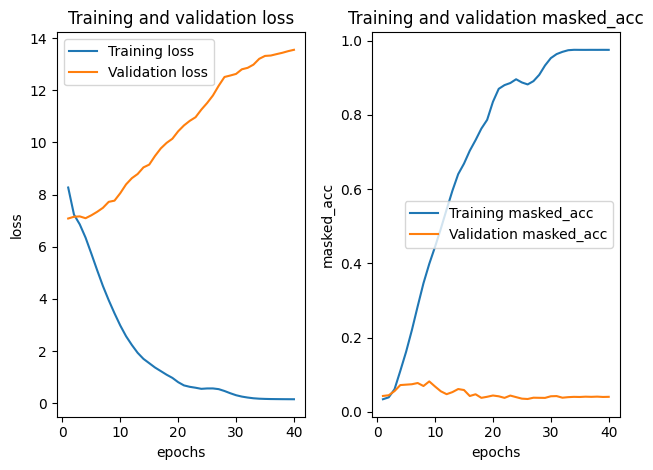

7.082533359527588 The best number of epocs for the validation loss is 1
0.0821613073348999 The best number of epocs for the validation accuracy is 9


In [ ]:
# debug
LEARNING_RATE = 0.001
NUM_EPOCHS = 40
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 4
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMEDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

build is called [[None, 2137], [None, 256]]


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream l

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict

build is called ((None, 2137), (None, 256))
Epoch 1/40


2024-07-04 23:43:19.875425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - loss: 8.7827 - masked_acc: 0.0251 - val_loss: 7.0910 - val_masked_acc: 0.0430
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 7.1730 - masked_acc: 0.0380 - val_loss: 7.1454 - val_masked_acc: 0.0465
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 6.8914 - masked_acc: 0.0567 - val_loss: 7.1076 - val_masked_acc: 0.0594
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 6.3849 - masked_acc: 0.0997 - val_loss: 7.0859 - val_masked_acc: 0.0794
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 5.7541 - masked_acc: 0.1583 - val_loss: 7.1990 - val_masked_acc: 0.0787
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 5.1020 - masked_acc: 0.2142 - val_loss: 7.2346 - val_masked_acc: 0.0794
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - loss: 4.4902 - masked_acc: 0.2702 - val_loss: 7.4336 - val_masked_acc: 0.0772
Epoch 8/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 3.9

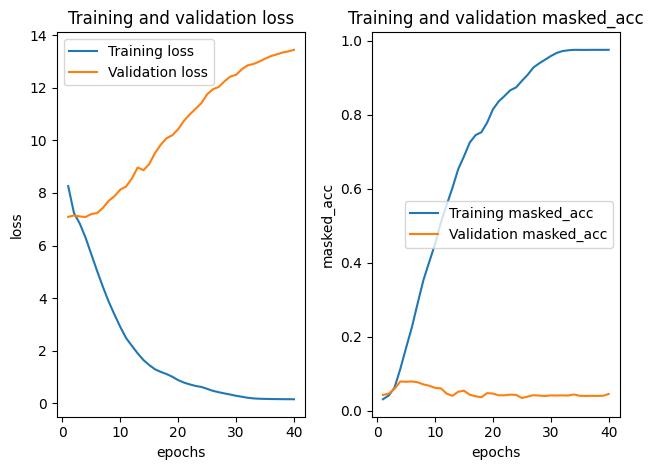

7.085932731628418 The best number of epocs for the validation loss is 4
0.07943623512983322 The best number of epocs for the validation accuracy is 6


In [ ]:
# debug same parameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 40
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 4
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMEDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

build is called [[None, 2137], [None, 256]]


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream l

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict

build is called ((None, 2137), (None, 256))
Epoch 1/40


2024-07-04 23:58:18.335898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 360ms/step - loss: 9.1193 - masked_acc: 0.0262 - val_loss: 7.2309 - val_masked_acc: 0.0433
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - loss: 7.2600 - masked_acc: 0.0377 - val_loss: 7.0780 - val_masked_acc: 0.0433
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - loss: 7.1125 - masked_acc: 0.0396 - val_loss: 7.0594 - val_masked_acc: 0.0493
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - loss: 6.8499 - masked_acc: 0.0596 - val_loss: 7.0448 - val_masked_acc: 0.0597
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 304ms/step - loss: 6.4304 - masked_acc: 0.1126 - val_loss: 7.0644 - val_masked_acc: 0.0703
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - loss: 5.9557 - masked_acc: 0.1483 - val_loss: 7.0073 - val_masked_acc: 0.0820
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 306ms/step - loss: 5.4943 - masked_acc: 0.1934 - val_loss: 7.0273 - val_masked_acc: 0.0826
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 306ms/step - loss: 5.0111 - masked_acc

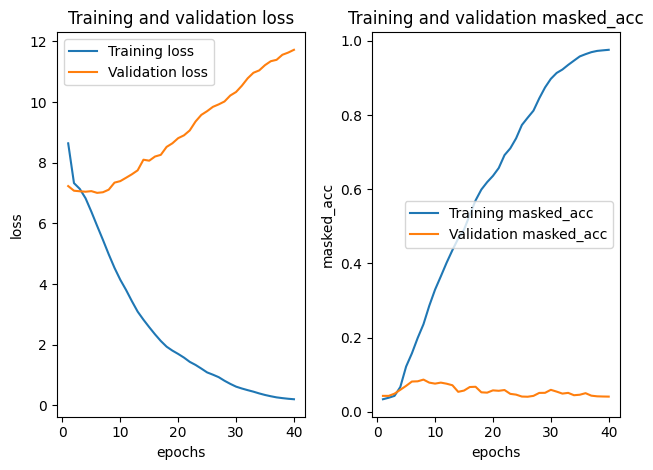

7.007280349731445 The best number of epocs for the validation loss is 6
0.08716803044080734 The best number of epocs for the validation accuracy is 8


In [ ]:
# debug batch size 2x
LEARNING_RATE = 0.001
NUM_EPOCHS = 40
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 8
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMEDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

build is called [[None, 2137], [None, 256]]


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream l

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict

build is called ((None, 2137), (None, 256))
Epoch 1/80


2024-07-05 00:12:12.223299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 762ms/step - loss: 9.3776 - masked_acc: 0.0205 - val_loss: 8.1873 - val_masked_acc: 0.0373
Epoch 2/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 682ms/step - loss: 7.9496 - masked_acc: 0.0338 - val_loss: 7.2770 - val_masked_acc: 0.0443
Epoch 3/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 645ms/step - loss: 7.2992 - masked_acc: 0.0380 - val_loss: 7.0616 - val_masked_acc: 0.0443
Epoch 4/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 653ms/step - loss: 7.1424 - masked_acc: 0.0381 - val_loss: 7.0386 - val_masked_acc: 0.0445
Epoch 5/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 653ms/step - loss: 6.9623 - masked_acc: 0.0431 - val_loss: 7.0389 - val_masked_acc: 0.0485
Epoch 6/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 639ms/step - loss: 6.7116 - masked_acc: 0.0681 - val_loss: 7.0085 - val_masked_acc: 0.0608
Epoch 7/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 658ms/step - loss: 6.4209 - masked_acc: 0.1151 - val_loss: 6.9503 - val_masked_acc: 0.0678
Epoch 8/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 644ms/step - loss: 6.0965 - masked_acc

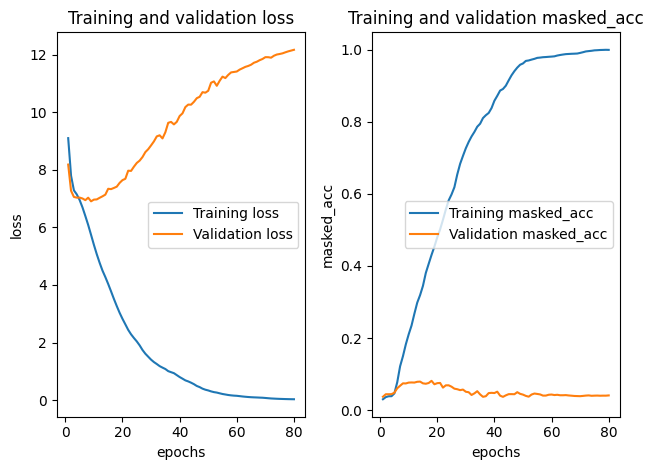

6.909355640411377 The best number of epocs for the validation loss is 9
0.08143775165081024 The best number of epocs for the validation accuracy is 18


In [ ]:
# debug batch size 4x
LEARNING_RATE = 0.001
NUM_EPOCHS = 80
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 16
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMEDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

build is called [[None, 2137], [None, 256]]
ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention t

2024-07-05 00:41:18.360838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


build is called ((None, 2137), (None, 256))
Epoch 1/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 9.5025 - masked_acc: 0.0155 - val_loss: 8.8352 - val_masked_acc: 0.0451
Epoch 2/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 8.6704 - masked_acc: 0.0383 - val_loss: 8.1087 - val_masked_acc: 0.0451
Epoch 3/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 7.9999 - masked_acc: 0.0383 - val_loss: 7.5751 - val_masked_acc: 0.0451
Epoch 4/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 7.5470 - masked_acc: 0.0383 - val_loss: 7.2374 - val_masked_acc: 0.0451
Epoch 5/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 7.2857 - masked_acc: 0.0383 - val_loss: 7.0830 - val_masked_acc: 0.0451
Epoch 6/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 7.1268 - masked_acc: 0.0383 - val_loss: 7.0382 - val_masked_acc: 0.0451
Epoch 7/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 6.9740 - masked_acc: 0.0390 - val_loss: 7.0270 - val_masked_acc: 0.0448
Epoch 8/160
13/13 ━━━━━━━━━━━━━━━━━━━━ 

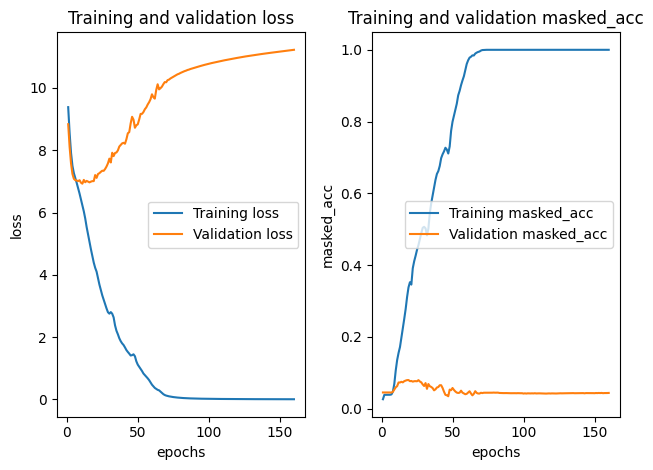

6.925014019012451 The best number of epocs for the validation loss is 11
0.07981985807418823 The best number of epocs for the validation accuracy is 19


In [ ]:
# debug batch size 8x
LEARNING_RATE = 0.001
NUM_EPOCHS = 160
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 32
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMEDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

build is called [[None, 2137], [None, 256]]
ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention t

In [ ]:
# debug batch size 16x
LEARNING_RATE = 0.001
NUM_EPOCHS = 320
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMEDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

2024-07-05 01:53:58.842808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


build is called ((None, 2137), (None, 256))
Epoch 1/320
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - loss: 9.5594 - masked_acc: 0.0092 - val_loss: 9.1957 - val_masked_acc: 0.0463
Epoch 2/320
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - loss: 9.0854 - masked_acc: 0.0433 - val_loss: 8.7331 - val_masked_acc: 0.0467
Epoch 3/320
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - loss: 8.6449 - masked_acc: 0.0387 - val_loss: 8.3249 - val_masked_acc: 0.0465
Epoch 4/320
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - loss: 8.2561 - masked_acc: 0.0385 - val_loss: 7.9758 - val_masked_acc: 0.0465
Epoch 5/320
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - loss: 7.9320 - masked_acc: 0.0385 - val_loss: 7.6906 - val_masked_acc: 0.0466
Epoch 6/320
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - loss: 7.6740 - masked_acc: 0.0390 - val_loss: 7.4723 - val_masked_acc: 0.0467
Epoch 7/320
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - loss: 7.4731 - masked_acc: 0.0415 - val_loss: 7.3111 - val_masked_acc: 0.0479
Epoch 8/320
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - lo

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

***
# SageMaker experiments

### Note (Experiment Date: 2024-07-06 23:55:00)

- Encoder length: 256, Decoder length: 128
- Batch size: 64
- **Encoder layers: 1**
- **Decoder layers: 1**
- Heads: 8
- Intermediate dim: 2048
- 2 times: verify reproductivity

#### Result

The accuracy got stuck around 24%. It is almost same as the model, where the number of Transformer layers is 6 and got stuck around 26%. It is inexplicable that the 6 times deeper model can improve the performance only 2%. This reason might be as follows:

- The vanishing gradient between multiple Transformer layers
- Defects

Hereby, the limit of the single Transformer layer model for text summarization task is around 24%. This is not surprising. If a single Transformer layer model achieves a high performance, it is inexplicable that Google and facebook used multiple Transformer layer model.

In [ ]:
LEARNING_RATE = 2e-5 # 0.00002
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMIDIATE_DIM = 2048
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMIDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

```
Epoch 96/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 303s 68ms/step - loss: 1.7534 - masked_acc: 0.2380 - val_loss: 1.9976 - val_masked_acc: 0.2348
Epoch 97/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 303s 68ms/step - loss: 1.7523 - masked_acc: 0.2382 - val_loss: 1.9970 - val_masked_acc: 0.2348
Epoch 98/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 303s 68ms/step - loss: 1.7512 - masked_acc: 0.2384 - val_loss: 1.9964 - val_masked_acc: 0.2350
Epoch 99/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 304s 68ms/step - loss: 1.7501 - masked_acc: 0.2387 - val_loss: 1.9958 - val_masked_acc: 0.2351
Epoch 100/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 303s 68ms/step - loss: 1.7491 - masked_acc: 0.2390 - val_loss: 1.9952 - val_masked_acc: 0.2352
Saving to summarization_model.keras
Successfully saved model to summarization_model.keras
```

<img src="img/download.png" />

1.9952380657196045 The best number of epocs for the validation loss is 100\
0.23516815900802612 The best number of epocs for the validation accuracy is 100

### Note (Experiment Date: 2024-07-06 23:55:00)

Large model

- Encoder length: 256, Decoder length: 128
- Batch size: 64
- Encoder layers: 6
- Decoder layers: 6
- Heads: 8
- Intermediate dim: 2048
- 2 times: verify reproductivity

#### Result

- 24 hours
- Got stuch around 26%, unexpectedly
- As the validation loss and acc indicates, if trained with all data, it possibly generalizes.

In some other models , it got stuck around 24%. If the model with same hyperparameters except the number of Transformer layers, which is 1, gets stuck around 24%, the reason might be the vanishing gradient.

Epoch 1/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 811s 166ms/step - loss: 3.3085 - masked_acc: 0.0427 - val_loss: 3.0278 - val_masked_acc: 0.0689
Epoch 2/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 739s 165ms/step - loss: 2.6804 - masked_acc: 0.0860 - val_loss: 2.8102 - val_masked_acc: 0.1252
Epoch 3/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 738s 164ms/step - loss: 2.5127 - masked_acc: 0.1271 - val_loss: 2.6848 - val_masked_acc: 0.1359
Epoch 4/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 736s 164ms/step - loss: 2.4187 - masked_acc: 0.1373 - val_loss: 2.6041 - val_masked_acc: 0.1451
Epoch 5/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 736s 164ms/step - loss: 2.3538 - masked_acc: 0.1452 - val_loss: 2.5418 - val_masked_acc: 0.1517
Epoch 6/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 735s 164ms/step - loss: 2.3015 - masked_acc: 0.1508 - val_loss: 2.4915 - val_masked_acc: 0.1567
Epoch 7/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 735s 164ms/step - loss: 2.2577 - masked_acc: 0.1557 - val_loss: 2.4468 - val_masked_acc: 0.1617
Epoch 8/100
4487/4487 ━━━━━

4487/4487 ━━━━━━━━━━━━━━━━━━━━ 743s 166ms/step - loss: 1.7492 - masked_acc: 0.2411 - val_loss: 1.9685 - val_masked_acc: 0.2407
Epoch 54/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 743s 166ms/step - loss: 1.7460 - masked_acc: 0.2419 - val_loss: 1.9664 - val_masked_acc: 0.2412
Epoch 55/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 742s 165ms/step - loss: 1.7430 - masked_acc: 0.2426 - val_loss: 1.9645 - val_masked_acc: 0.2416
Epoch 56/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 743s 166ms/step - loss: 1.7400 - masked_acc: 0.2433 - val_loss: 1.9623 - val_masked_acc: 0.2421
Epoch 57/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 743s 166ms/step - loss: 1.7371 - masked_acc: 0.2439 - val_loss: 1.9606 - val_masked_acc: 0.2425
Epoch 58/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 741s 165ms/step - loss: 1.7343 - masked_acc: 0.2446 - val_loss: 1.9589 - val_masked_acc: 0.2429
Epoch 59/100
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 744s 166ms/step - loss: 1.7315 - masked_acc: 0.2452 - val_loss: 1.9573 - val_masked_acc: 0.2432
Epoch 60/100
4487/4487 ━━━━━━━━━━

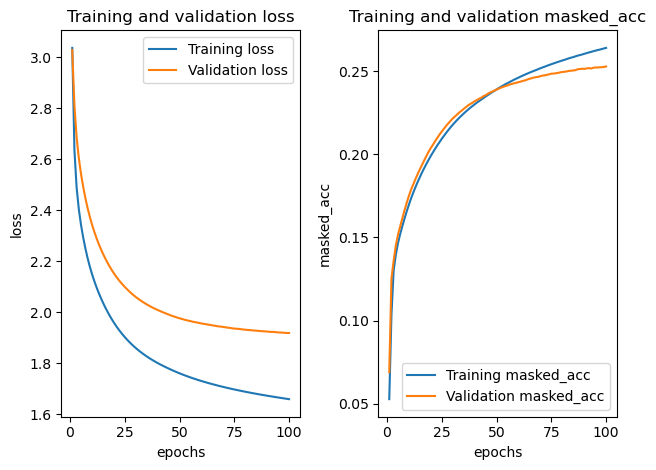

1.9179842472076416 The best number of epocs for the validation loss is 99
0.25299450755119324 The best number of epocs for the validation accuracy is 100


In [ ]:
# batch: 64, num_heads: 8, transformer_intermediate_dim: 2048
LEARNING_RATE = 2e-5 # 0.00002
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 6
NUM_DECODERS = 6
NUM_HEADS = 8
INTERMIDIATE_DIM = 2048
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMIDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

### Note (Experiment Date: 2024-07-05 00:00:00)

- Encoder length: 256, Decoder length: 128
- Batch size: 64
- Strip tags, url, and so on
- 2 times: verify reproductivity

Eventually, the waveform on the validation loss and accuracy got close to the desired shape. At least the batch size should be more than 64. HTML tags, URLs, and so on must be removed. The encoder sequence length was 256, which is much shorter than before. The sentences that are used for the summary might tend to be located at the beginning of the article.

2024-07-04 16:14:37.407464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


build is called ((None, 256), (None, 128))
Epoch 1/40


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore des

4487/4487 ━━━━━━━━━━━━━━━━━━━━ 223s 47ms/step - loss: 6.0479 - masked_acc: 0.1390 - val_loss: 4.8427 - val_masked_acc: 0.2081
Epoch 2/40
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 209s 47ms/step - loss: 4.8649 - masked_acc: 0.2055 - val_loss: 4.6521 - val_masked_acc: 0.2234
Epoch 3/40
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 209s 47ms/step - loss: 4.6821 - masked_acc: 0.2192 - val_loss: 4.5851 - val_masked_acc: 0.2296
Epoch 4/40
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 209s 47ms/step - loss: 4.5991 - masked_acc: 0.2261 - val_loss: 4.5527 - val_masked_acc: 0.2323
Epoch 5/40
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 210s 47ms/step - loss: 4.5484 - masked_acc: 0.2304 - val_loss: 4.5324 - val_masked_acc: 0.2344
Epoch 6/40
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 209s 47ms/step - loss: 4.5129 - masked_acc: 0.2333 - val_loss: 4.5196 - val_masked_acc: 0.2359
Epoch 7/40
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 209s 47ms/step - loss: 4.4863 - masked_acc: 0.2355 - val_loss: 4.5109 - val_masked_acc: 0.2371
Epoch 8/40
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 210s 47ms/

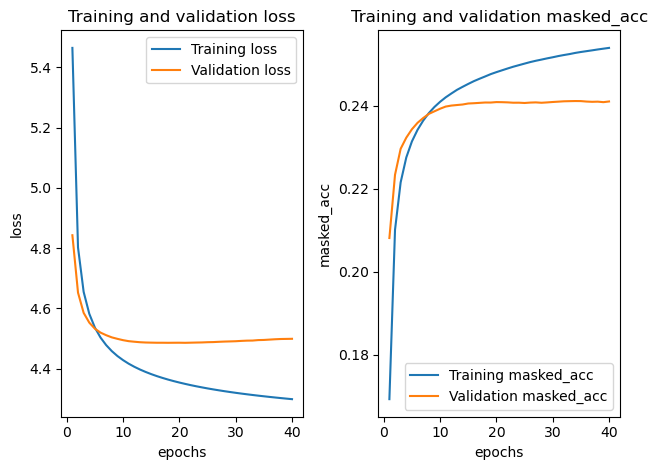

4.4857025146484375 The best number of epocs for the validation loss is 21
0.24115076661109924 The best number of epocs for the validation accuracy is 34


In [ ]:
# debug
LEARNING_RATE = 0.001
NUM_EPOCHS = 40
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMEDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=get_default_optimizer(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=DECAY_STEPS,
        decay_rate=DECAY_RATE
    ),
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

build is called [[None, 256], [None, 128]]


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict